In [62]:
import pandas as pd
import re
import pytz
import pandas as pd
from collections import Counter
from difflib import SequenceMatcher

In [63]:
# Read the list of filenames from the configuration file
with open('../file_list.txt', 'r', encoding='utf-8') as config_file:
    file_names = config_file.read().splitlines()

# Regex pattern to match the data format
pattern = r'\[(.*?)\] (.*?): (.*)'

# Initialize an empty list to store parsed data
datalist = []
stream_count = 0
# Iterate over each specified file
for file in file_names:
    full_path = f"../data/{file}"
    with open(full_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        for line in lines:
            match = re.match(pattern, line)
            if match:
                date, user, message = match.groups()
                datalist.append([date, user, message,stream_count])
    stream_count = stream_count + 1



In [64]:
# Create a DataFrame from the parsed data
data = pd.DataFrame(datalist, columns=["date", "user", "message","stream"])
data['date'] = pd.to_datetime(data['date'])



In [65]:
def convert_utc_to_cet(df, date_column='date'):
    
    # Make a copy to avoid modifying the original
    df = df.copy()
    
    # Ensure timestamps are UTC aware
    if df[date_column].dt.tz is None:
        df[date_column] = df[date_column].dt.tz_localize('UTC')
    elif df[date_column].dt.tz != pytz.UTC:
        df[date_column] = df[date_column].dt.tz_convert('UTC')
    
    # Convert to CET/CEST (Europe/Berlin includes proper DST handling)
    df[date_column] = df[date_column].dt.tz_convert('Europe/Berlin')
    
    return df

data = convert_utc_to_cet(data)

In [66]:
seventvlis = ['arnoldHalt',
 'SEXO',
 'peepoMarch',
 'doroHEAD',
 '4stars',
 'Rizzler',
 'ppL',
 'WAIT',
 'SpeedLaugh',
 'GetALoadOfThisGuy',
 'ModAbuse',
 'DoroCheer',
 'BHOP',
 'WhoAsked',
 'SCRAPETHATSHITJOHNNY',
 'OverwhelminglyWholesome',
 'SAJ',
 'NOW',
 'LETSFUCKINGJOE',
 '3stars',
 'aga',
 'ome47',
 'OMEGALUL',
 'Gayge',
 'peepoFat',
 'HolyFuck',
 'RAHH',
 'SNIFFA',
 'xdd',
 'EDGE',
 'LetsBingo',
 '!lurk',
 'Caught',
 'monakS',
 'ahmadmuhsin',
 'wade',
 'parasocial',
 'EdwardStare',
 'ISeeYou',
 'YouWouldntGetIt',
 'Banties',
 'DRAIN',
 'banties',
 'PepeHands',
 'WidelebronJAM',
 'Lamonting',
 'CAUGHT',
 'LOL',
 'FeelsDankMan',
 'pepeJAM',
 'ayo',
 '!unfollow',
 'glorp',
 'Waiting',
 'owoshy',
 'wideduckass',
 'HELLO',
 'Pepega',
 'DeathIncoming',
 'brbToilet',
 'ads',
 'despair',
 'TWEAK',
 'sus',
 'THINKING',
 'bruv',
 'ROFL',
 'juh',
 'skip',
 'OuttaPocket',
 'RareParrot',
 'emergencylandingstrip',
 'FirstTimePepega',
 'WideCatGroove',
 'Clueless',
 'ADHD',
 'StoryTime',
 'Delusional',
 'firewriting',
 'ragebait',
 'Aloo',
 'ome15',
 'peepoHug',
 'PagMan',
 'Based',
 'OMFG',
 'PepegaAim',
 'VeryPog',
 'OVERWORKING',
 'LL',
 'myIQ',
 'doroFiddy',
 'MUGA',
 'SAVEME',
 'GotEEM',
 'PagChomp',
 'Surfing',
 'PokiShare',
 'FEINFEINFEINFEINFEINFEINFEINFEI',
 'FeelsLagMan',
 'flowerr',
 'speed1',
 'NAUR',
 'BINGO',
 'STREAMERSGIVINGTHEWORSTFUCKINGTAKESINEXISTENCE',
 'gothKiss',
 'WAYTOODANK',
 'ppOverheat',
 'ManchesterUnited',
 'dogJAM',
 'ewphop',
 'fortnite',
 'Doc1v1',
 'GotCaughtTrolling',
 'nonono',
 'dash',
 'veryDoro',
 'YAPPING',
 '!boost',
 'Bleh',
 'Sadge',
 'GIGAMOD',
 'dudWhat',
 'gPls',
 'YANITED',
 'Alarm',
 'WHOAAA',
 'HOLY',
 'TheVoices',
 'PokiShareW',
 'SpeedR',
 'RoxyPotato',
 'STREAMER',
 'emo2',
 'WatchingStream',
 'POVbornbefore2000',
 'lemon',
 'RaveTime',
 'dome44',
 'shutup',
 'ome55',
 'gg',
 'typeshit',
 'peepoLeave',
 'Paul',
 'unibrow',
 'GRRR',
 'lebronArrive',
 'DoroTalkingAgain',
 'ome29',
 'CrayonTime',
 'ANOTHERONE',
 'saythatagain',
 'monkaW',
 'peepoHey',
 'ONEMORE',
 'Considering',
 'Explosion',
 'LULE',
 'peepoKiss',
 'Joel',
 'CLOWNDETECTED',
 'ChillGuy',
 'Exerpas',
 'walterShocked',
 'ohneFinger',
 'SteerR',
 'lebronJAM',
 '+1',
 'EZdodge',
 'CLEAN',
 'ogo',
 'yesbro',
 'BantiesPaulBeef',
 'WalterVibe',
 'SOYSCREAM',
 'Pffttt',
 'WW',
 'VeryKey',
 'ome14',
 'spongePls',
 'Bello',
 'bieberDougie',
 'MODDING',
 ':tf:',
 'heyywithrizz',
 'HowDoWeTellHer',
 'sdd',
 'plinkVibe',
 'omeClap',
 'xJAM',
 'RussiaPls',
 'DRAMA',
 'firsttimebuh',
 'AINTNOWAY',
 'BUSSIN',
 'TriJam',
 'Modding',
 'WePaid',
 'Loading',
 'wideSpeedLaugh3',
 'ome104',
 'goblin44',
 'CaughtIn4K',
 'omEE',
 '0pixel',
 'arthur',
 'xqcL',
 'Borfday',
 'jacob3',
 '4Weird',
 'bah',
 'RealForsen',
 'BOOBA',
 'doroMAD',
 '5Head',
 'xqcTwerk',
 'Ohh',
 'peepoDJ',
 'HeDisconnected',
 'SCHEISSE',
 'scawy',
 'hi',
 'Drake',
 'RIPBOZO',
 'GAMBA',
 'RightThere',
 'JermaSoy',
 'wig',
 'WHOLETHERSLAY',
 'RAGEY',
 'peepoShy',
 'AIWITHTHEBRAIDS',
 'lurkk',
 'PepegaChat',
 'YeahThatsWhatIWouldaDid',
 'catDespair',
 'FellOff',
 'WIDEALERT',
 'Plotge',
 'mods',
 'Parasocial',
 'WakeTheFuckUpSamuraiWeHaveACityToBurn',
 'brb',
 'hackingCD',
 'luton',
 'heh',
 'BELIEVERS',
 'mhm',
 'Flirt',
 'PTSD',
 'LieMeter',
 'THIS',
 'uuh',
 'doroGHOST',
 'niceguy',
 'TriSad',
 'catSigh',
 'RememberTheDays',
 'OLDWORK',
 '(7TV)',
 'LookUp',
 'weirdChamp',
 'peepoTalk',
 'helvete',
 'EDITING',
 'OVERWATCH',
 'JESSE',
 'amongE',
 'COMEHERE',
 'MeRN',
 'emo',
 'Chatting',
 'goaler',
 'catJAM',
 'biteof87',
 'winton',
 'Looking',
 'om',
 'TRUEING',
 'peepoHappy',
 'VIDEOGAME',
 'justinbieber',
 'pickle',
 'SurE',
 'SLAY',
 'YAAY',
 'merch',
 'unmod',
 'GULP',
 'reckH',
 '5stars',
 'NoMaidens',
 'pepeW',
 'Sippin',
 'totallylistening',
 'WaitingForLove',
 'BANGER',
 'D:',
 'Dave',
 'WAHHH',
 'PepegaReading',
 'Steve',
 'forsenPls',
 'dome32',
 'OMEYES',
 'Jammies',
 'Listening',
 'GlorpMeeting',
 'glorprave',
 ':33',
 'BatChestAbove',
 'sisyphus',
 'BORGIR',
 'peepoPride',
 'NOIDONTTHINKSO',
 'INTENSEGAMING',
 '!drop',
 'lore',
 'NAHHHH',
 'phpk',
 'ImtiredBoss',
 'oopsie',
 'ok',
 'MAJ',
 'KKalinka',
 'FeelsWeirdMan',
 'NAvsEU',
 'ome101',
 '3Heading',
 'vibePls',
 'GoodTake',
 'ome105',
 'Yooo',
 'ome99',
 'omeStare',
 'LastTimeChatter',
 'Cinema',
 'HARAM',
 'Devious',
 'WideRaveTime',
 'Yoink',
 'AAAAAAAAUHGGH',
 'StreamEnding',
 'Johnporkiscalling',
 'SCHIZO',
 'FirstTimeChatter',
 'Waddup',
 'catBusiness',
 'modCheck',
 'FeelsStrongMan',
 'CatTime',
 'PianoTime',
 'FLASHBANG',
 'OOOO',
 'Susge',
 'nuhuh',
 'SUSSY',
 'NAILSING',
 'classic',
 'deadassFaint',
 'chatters',
 'ome44',
 'HABIBI',
 'ryanArrive',
 'joever',
 'Cuck',
 'pepeGun',
 'midloud',
 'LOCKIN',
 'ome32',
 'FARMING',
 'Scared',
 'matSad',
 'BEGGING',
 'GotCaughtCheating',
 'poroPls',
 'PepePls',
 'Sits',
 'sotruebestie',
 'Tuckge',
 'onggang',
 'widetime',
 'vas',
 'OneGuy',
 'HELP',
 'gkeywide',
 'life',
 'freddy',
 'GoodBye',
 'ome69',
 'AAAA',
 'AURA',
 'omeJudging',
 'doggoSlava',
 'GIGACHAIR',
 'pKitten',
 'SADge',
 'MYLIFE',
 'YouGotMe',
 'buhFlipExplode',
 'peepoSmile',
 'ome18',
 'glorpdetective',
 'Flushed',
 'Reacting',
 'peepoSad',
 'agahi',
 'AlienPls',
 'MODS',
 'characterSelected',
 'PotFriendDance',
 'Hmm',
 'MyExistenceIsNothingButAGrainOfSandComparedToTheEntireScaleOfTheUniverse',
 'FUNNY',
 'Barry63',
 'forsenCD',
 'SpeedL',
 'Jay',
 'GOONING',
 'gkitten',
 'omeJAM',
 'FeelsLateMan',
 'wot',
 'bog',
 'WideHUH',
 '1star',
 'MeWhenIBuyEgyptianProperty',
 'xqc32',
 'smh',
 'Pipege',
 'SERIOUSLY',
 ':3',
 'doroKick',
 'peepoRiot',
 'Whenyourinnerwolfreleases',
 'nanaAYAYA',
 'catSmash',
 'catKISS',
 'RIRI',
 'SCORN',
 'IMGOINGINSANEANDCOMPLETELYLOSINGITAAAAAAAAAAAHHHHHHH',
 'happi',
 'KEKW',
 'jacob2',
 'NAHH',
 'NOCHECKMARKS',
 'YESS',
 'buh',
 'EZ',
 'POLICE',
 'BaileyChamp',
 'peepoDoubters',
 'WeDoNotCare',
 'cokeBreak',
 'peepoComfy',
 'doroJAM',
 'ReallyMad',
 'ohhh',
 'KaiCenatOhiogyatwithskibiditoiletwatchingtheWrizzhappeningrightinfrontofhimwithfanumtaxtaxingthegyat',
 'pepeAgony',
 'xqcDespair',
 'bye',
 'WineTime',
 'test',
 'IFISPEAK',
 'HUH',
 'LittleTrolling',
 'axeIF',
 'GIGACLAUS',
 'Staring',
 'ratio',
 'unemployment',
 '44emo',
 'notxqcL',
 'barack',
 'imback',
 'itsover',
 'LiterallyMe',
 'Pointless',
 'BUSSERS',
 'Broadcaster',
 'catTwerk',
 'KanyeStare',
 'peepoLegs',
 'Dentge',
 'Peace',
 'Reddit',
 'Panam',
 'drooling',
 'NOSHOT',
 'EldenRoll',
 'LiveReaction',
 'LETHERCOOK',
 'iDrive',
 'Gooner',
 'JokerHAHA',
 'LETSGO',
 'okak',
 'DOCBOZO',
 'MARIO',
 'Clap2',
 'ome41',
 'PARASOCIAL',
 'GODDID',
 'YOOLOOKATTHISCATDOINITSLILDANCYDANCEINTOABREAKDANCEMOVE',
 'Shruge',
 'MicTime',
 'WasZumPenis',
 'VibePls',
 'docAwaken',
 'batPls',
 'homelessPOV',
 'plonk',
 'UltraMad',
 'noonecares',
 'Tomfoolery',
 'COPIUM',
 'DrDisrespect',
 'Please',
 'FeelsGladMan',
 'ome96',
 'MONKE',
 'PAUSENEMOGU',
 'essaying',
 'WHOLETHERCOOK',
 'ratomilton',
 'ohno',
 'Prayge',
 'freakbob',
 'Madge',
 'peepoEvil',
 'WAJAJA',
 'hue',
 'xqcGoofy',
 'BigD',
 'ThePaulers',
 'EEK',
 'freakyfredday',
 'wallE',
 'JumpScared',
 'GENIUS',
 'WidezyzzPls',
 '!play',
 'KENOUGH',
 'DogLookingWickedAndCool',
 'raid',
 'Clown',
 'TriKool',
 'FINALLY',
 'zyzzJAM',
 'o7',
 'Batman',
 'Dime',
 'qq',
 'iAsked',
 'OMEGALULiguess',
 'CLIPPERS',
 'ApuApustaja',
 'HandsUp',
 'fnaf',
 'MEGALUL',
 'Wisdom',
 'Swag',
 'Enough',
 'girlBoss',
 'MONKA',
 'gooner',
 'giancarlo',
 'Noppers',
 'ZhongXina',
 'lockedin',
 'AlienDance',
 'Cyat',
 'peepoBelievers',
 'peepoClap',
 'Gaught',
 'catPls',
 'CS2',
 'VIEWERS',
 'JustAChillGuy',
 'GAGAGA',
 'omE',
 'ome52',
 'FristTime',
 ':0',
 'BOOM',
 'Stare',
 'chilling',
 'notListening',
 'Thinking',
 'NOTED',
 'YOOOLOOKATTHISCOCKWITHDADRIPSHII',
 'nymnCorn',
 'Ant',
 'barryArrive',
 'UGH',
 '2stars',
 'JARVIS',
 'gigl',
 'CatEat',
 'xqcBOZO',
 '1DLove',
 '!join',
 'jah',
 'KKonaW',
 'ThisChat',
 'WDYM',
 'RainTime',
 'AWOO',
 'batman',
 'KKool',
 'OHMYGAWDD',
 'LULW',
 'Clap',
 'fein',
 'WELSH',
 'otag',
 'Chillin',
 'spfLEAN:()wiltee_()tonyhawkproskater4:-:-:_FREEWAVE3-encinoman--:enteringwalmart:-wheezethelean-123',
 'peepoGiggles',
 'War',
 'nt',
 'YamesBond',
 'crabPls',
 'GAMING',
 'BASED',
 'catAsk',
 'forsenLaughingAtYou',
 'OMEGADANCE',
 'pleading',
 '3Head',
 'Evilge',
 'FeelsBlackScreen',
 'GYAT',
 'AreYouSeriousRightNeow',
 'GIGACHAD',
 'silliness',
 'HowDoWeTellHim',
 'ANGRE',
 'MYMAINGOAL',
 'pL',
 'PEEPEES',
 'Dorozea',
 'zyzzBass',
 'FeelsOkayMan',
 'doroAunt',
 'YOUDIED',
 'steve',
 'Bloons',
 '1984',
 'xQcVeryWide',
 'FirstTimeBackseating',
 'xqcScHIZO',
 'pepePoint',
 'PogU',
 'ome4',
 'drukiDnace',
 'CoolMonkey',
 'doroBiceps',
 'ome79',
 'HECOOKING',
 'VALORANT',
 'peepoFarmer',
 'eww',
 'PepoG',
 'waa',
 'Bedge',
 'TRIVSsorry',
 'ThisIsMinecraft',
 'susDog',
 'GivenUp',
 'wrapitup',
 'itstime',
 'IMAGINENOTHAVING7TVGETFUCKEDNON7TVUSERSIMAGINENOTHAVING7TVGETFUCKEDNON7TVUSERSIMAGINENOTHAVING7TVGET',
 'GameplayTime',
 'SCAMMED',
 'Celebrating',
 'vibeeparty',
 'Smoge',
 'MoneyRain',
 'ICANT',
 'FeelsTiredMan',
 'FeelsWowMan',
 'donoWall',
 'me:',
 'HAH',
 'KeyShaker',
 'WeGood',
 'gachiGASM',
 'peepoAds',
 'FirstTimeTest',
 'ome21',
 'Gogging',
 '1Directioning',
 'GROOTING',
 'squadHips',
 'monkaTOS',
 'hiiii',
 'Belling',
 'docnotL',
 'PauseMan',
 'DespairRyan',
 'RebeccaBlack',
 'owoCheer',
 'MVPFarallah',
 'AlienPls3',
 'doroL',
 'Shits',
 'gachiBASS',
 'AYAYA',
 'Heisenberj',
 'MVP',
 'mikuPLS',
 'Headbang',
 'WeAreLive',
 'speed44',
 'FeelsBadMan',
 'EDM',
 'AwHellNah',
 'PagBounce',
 'Aware',
 'PartyParrot',
 'DemonTiming',
 'doroCD',
 'paul',
 'WHATAFUCKEDUPDAY',
 'Lithuanian',
 'WideHardo',
 'jacob4',
 'pokiFlirt',
 'Beatles',
 'HUHHHHHHHHHH',
 'Voices',
 'wideDvaAss',
 'waltuh',
 'BillyApprove',
 'PETPET',
 'DIESOFCRINGE',
 'ta',
 'Mog',
 'damily',
 'Adge',
 'ppHop',
 'HACKERMANS',
 'HarryStylesKiss',
 'Damn',
 'Nerd',
 'GuitarTime',
 'TeamEDWARD',
 'Thinking2',
 'ACTINUP',
 'JokerLaugh',
 'HEYYY',
 'XDoubt',
 'popipopipipopipo',
 'fadedthanaho',
 'BRUHMM',
 'ImNotOk',
 'Alfred',
 'AREYOUAGIRL',
 'glizzyoverdrive',
 'Jackass',
 'dreamwastaken',
 'woah',
 'hesRight',
 'YEP',
 'ome57',
 'CHADDING',
 'Cooked',
 'doid',
 'WAITWAITWAIT',
 'JustHowItIs',
 'speed25',
 'mutted',
 'xqcFuel',
 'widemonkaGIGAftRobertDowneyJr',
 'waiting',
 'BibleThump',
 'dimacut',
 'FiddyWtf',
 'AWOOGA',
 'MathTime',
 'SNACKING',
 'gamily',
 'PepeLaugh',
 'Smile',
 'FirstTimeome44',
 'TITANHOLO',
 'WHAT',
 'Alright',
 'BOOMIES',
 'Deadass',
 'NOWAYING',
 'BasedGod',
 'phew',
 'Memories',
 'Ignored',
 'CatCozy',
 'greetingsladies',
 'xar2EDM',
 'DOUBTERS',
 'SCATTER',
 'Sadding',
 'ome5',
 'john',
 'goster',
 'duaKiss',
 'Bruh',
 'YIPIEE',
 'goat',
 'RaveDance',
 'nyanPls',
 'HEHE',
 'gmoney',
 'TheWolfInMe',
 'JustAnotherDay',
 'FirstTimeChadder',
 'NAHHH',
 '4House',
 'TIMEOUT',
 'COCKA',
 'doroFlex',
 'NOOOOO',
 'preePfftttt',
 'muted',
 'GREEDY',
 'RiddleMeThis',
 'ome808',
 'axelF',
 'PRIMERS',
 'jacob1',
 'Fiddy',
 'WOT',
 'monkeySip',
 'NAILS',
 'peepoStop',
 'VeryPogftxQcInTheShower',
 'LMAOFREAKY',
 'WICKED',
 'Martin',
 'TakingNotes',
 'DinkDonk',
 'Xd',
 'FirstTimeEmoteFail',
 'xd',
 'HaltEinfachDeineFresseDuHurensohn',
 'OnMyWayToDoroMomHouse',
 'NOHORNY',
 'ome44444444',
 'Ogre',
 'Dinema',
 'hiii',
 'GETOUT',
 'waga',
 'peepoPls',
 'Freedom',
 'FirstTimeGooner',
 'HOBBY',
 'donowall',
 'SCHTOP',
 'gettingjiggywithit',
 'speed21',
 'doroRip',
 'BAND',
 'plink-182',
 'wideReacting',
 'ome10',
 'xqcSlam',
 'NODDERS',
 'ome90',
 'MYHEARTILOVEDHER',
 'peepoLove',
 'AREYOUAGIRLFtxQcYellingAtYou',
 'xqcTake',
 'doster',
 'IGON',
 '4Shrug',
 'Life',
 'DIESOFGRINCH',
 'MarblesTime',
 'fembajJAM',
 '7TV',
 'Cuh',
 'AIM',
 'gachiHYPER',
 'paidchatter',
 'Acknowledged',
 'uwu',
 'Smurfing',
 'Banger']

In [67]:
replace_map = {
    "Banties1g": "banties_x",
    "banties1g": "banties_x",
    "fyodor_m_d1821": "fyredoor4",
    "chili_poe": "chili_con_bacon",
    "CHILI_POE": "chili_con_bacon",
    "Wirelesss_": "W1r3lesss",
    "treklul": "trek44_",
    "ttrek_": "trek44_",
    "TriplesingleJ": "TripleSingleJames",
    "uuccugr": "uwu_cougar"
}
data["user"] = data["user"].replace(replace_map)

In [68]:
# Now, update the 'message' column
# Iterate through each key-value pair in your replace_map
# For each old username (key), replace it with the new username (value) in the 'message' column
for old_username, new_username in replace_map.items():
    # Using regex=False ensures that the old_username is treated as a literal string.
    # This is important if usernames might contain special characters used in regular expressions.
    data['message'] = data['message'].str.replace(old_username, new_username, regex=False)


In [69]:
tv7 = "Clown Explosion hackingCD MathTime MoneyRain PokiShare TakingNotes :0 :33 !boost +1 1DLove 3Head 3Heading 4Weird 5Head Acknowledged ACTINUP ADHD AIM AIWITHTHEBRAIDS Alfred AlienDance AlienPls AlienPls3 Aloo amongE ANGRE ANOTHERONE AREYOUAGIRL arnoldHalt AWOO axelF barack Based BASED batPls Beatles Bedge BEGGING Belling BHOP BigD Bloons BOOBA BOOMIES Borfday BORGIR brbToilet Broadcaster BRUHMM BUSSERS BUSSIN catAsk catBusiness catDespair catJAM catPls catSmash CatTime catTwerk Caught CaughtIn4K CHADDING Chillin Clap CLEAN CLIPPERS CLOWNDETECTED COCKA cokeBreak COMEHERE CoolMonkey COPIUM crabPls Cuck Cuh Cyat Dave deadassFaint Delusional DemonTiming Dime DinkDonk docAwaken DOCBOZO docnotL doggoSlava dogJAM DogLookingWickedAndCool donowall doroCD DoroCheer doroFiddy doroFlex doroGHOST doroHEAD doroJAM doroL doroMAD DOUBTERS DRAIN Drake DrDisrespect drooling duaKiss dudWhat emo emo2 FeelsTiredMan FeelsWowMan FellOff fembajJAM FiddyWtf FLASHBANG Flirt flowerr Flushed forsenCD forsenLaughingAtYou FUNNY gachiHYPER GAMBA GAMING GIGACHAD GIGACHAIR glizzyoverdrive GODDID Gogging GotEEM gothKiss gPls GuitarTime HABIBI HACKERMANS HaltEinfachDeineFresseDuHurensohn HandsUp happi HARAM Headbang HeDisconnected HEHE Heisenberj heyywithrizz HEYYY Hmm HOBBY HOLY homelessPOV HUH ICANT IFISPEAK Ignored IMAGINENOTHAVING7TVGETFUCKEDNON7TVUSERSIMAGINENOTHAVING7TVGETFUCKEDNON7TVUSERSIMAGINENOTHAVING7TVGET ISeeYou itsover Jackass Jay JESSE joever john JokerHAHA JokerLaugh JumpScared JustAnotherDay justinbieber KanyeStare KENOUGH KKalinka KKonaW KKool Lamonting lebronJAM LetsBingo LETSGO Life Lithuanian LittleTrolling Loading Looking LULW lurkk Madge MAJ ManchesterUnited MicTime Modding mods Mog monakS monkaTOS monkaW MONKE monkeySip muted MYHEARTILOVEDHER NAHH NAHHH NAHHHH NAILS NAILSING NAUR Nerd NODDERS NOIDONTTHINKSO NoMaidens NOOOOO Noppers NOSHOT notxqcL NOW nt ohhh ohneFinger ohno ok OLDWORK omEE OMEGALUL omeStare OnMyWayToDoroMomHouse OOOO oopsie OuttaPocket OverwhelminglyWholesome owoCheer PagBounce PagChomp PagMan parasocial PARASOCIAL PEEPEES peepoClap peepoComfy peepoDJ peepoEvil peepoFat peepoHey peepoKiss peepoLeave peepoLegs peepoMarch peepoPride peepoShy peepoSmile peepoTalk pepeAgony Pepega PepegaAim PepegaChat pepeGun PepeHands pepePoint pepeW PepoG Pffttt pickle Pipege pL PogU pokiFlirt PotFriendDance POVbornbefore2000 ppHop ppOverheat Prayge RAHH RaveDance RaveTime Reacting RememberTheDays RIPBOZO RIRI Rizzler ROFL RussiaPls ryanArrive Sadding SAJ SCAMMED Scared SCHIZO SCHTOP SEXO Shits Sippin sisyphus Smile Smoge SNIFFA spfLEAN:()wiltee_()tonyhawkproskater4:-:-:_FREEWAVE3-encinoman--:enteringwalmart:-wheezethelean-123 spongePls squadHips Staring STREAMER SurE susDog SUSSY Swag TeamEDWARD TheVoices TheWolfInMe Thinking THINKING Thinking2 TIMEOUT Tomfoolery totallylistening TriKool TriSad TRIVSsorry TRUEING Tuckge TWEAK UGH unmod uwu vibePls VibePls VIEWERS WAHHH WAIT Waiting WaitingForLove WAITWAITWAIT WAJAJA WeDoNotCare weirdChamp WELSH WePaid wig WW xar2EDM xd xqcBOZO xqcDespair xqcFuel xqcGoofy xqcTake xqcTwerk YANITED YAPPING YIPIEE Yoink YOOLOOKATTHISCATDOINITSLILDANCYDANCEINTOABREAKDANCEMOVE Yooo YOOOLOOKATTHISCOCKWITHDADRIPSHII ZhongXina :tf: 1984 1Directioning AINTNOWAY AreYouSeriousRightNeow Aware BANGER Banties barryArrive BatChestAbove BELIEVERS bieberDougie bog bruv buh CatCozy chilling classic Dentge despair DespairRyan Devious Devious Doc1v1 DRAMA EdwardStare Evilge fadedthanaho FARMING Fiddy fortnite GAGAGA gamily gigl girlBoss GivenUp gkitten HarryStylesKiss HELLO hesRight hi ImNotOk itstime LETHERCOOK LETSFUCKINGJOE LiterallyMe LOCKIN MARIO Martin matSad Memories mhm ModAbuse MVP niceguy nonono o7 OHMYGAWDD okak omE OMEGALULiguess owoshy peepoBelievers peepoDoubters peepoGiggles peepoHug peepoLove peepoLove peepoStop pepeJAM pKitten Plotge Pointless poroPls PRIMERS PTSD RAGEY ratio ReallyMad Reddit RiddleMeThis Sadge SADge SAVEME Shruge silliness Sits SLAY sotruebestie SOYSCREAM Stare StreamEnding Susge ThePaulers UltraMad VALORANT VeryPog wallE WatchingStream WeAreLive WHAT WHOAAA WHOLETHERCOOK WHOLETHERSLAY WICKED WOT wrapitup Xd xJAM xqcSlam YEP YouWouldntGetIt zyzzBass !play AAAAAAAAUHGGH AREYOUAGIRLFtxQcYellingAtYou ayo brb CAUGHT chatters CS2 damily DeathIncoming DIESOFCRINGE dimacut Dorozea EDITING Enough FINALLY firsttimebuh FirstTimeChadder FirstTimeChatter GameplayTime gettingjiggywithit gg GotCaughtCheating GotCaughtTrolling GREEDY GRRR HowDoWeTellHim iAsked ImtiredBoss INTENSEGAMING KEKW KeyShaker lebronArrive LieMeter Listening LOL LookUp luton MarblesTime me: MeRN MONKA MyExistenceIsNothingButAGrainOfSandComparedToTheEntireScaleOfTheUniverse MYLIFE noonecares notListening NOWAYING Ohh OVERWATCH paul Peace popipopipipopipo raid RightThere SNACKING STREAMERSGIVINGTHEWORSTFUCKINGTAKESINEXISTENCE THIS TITANHOLO unemployment uuh VeryKey vibeeparty Voices Waddup waiting walterShocked WalterVibe War WHATAFUCKEDUPDAY Whenyourinnerwolfreleases WhoAsked WideHUH xqcL YouGotMe zyzzJAM PokiShareW WIDEALERT WideRaveTime !join !lurk !unfollow Adge ads ahmadmuhsin BantiesPaulBeef BINGO bye Cinema doroBiceps DoroTalkingAgain GoodTake HAH hiii iDrive imback IMGOINGINSANEANDCOMPLETELYLOSINGITAAAAAAAAAAAHHHHHHH jacob1 jacob2 jacob3 jacob4 Joel LastTimeChatter NAvsEU NOCHECKMARKS NOHORNY ome32 ome5 OMEYES OMFG OneGuy ONEMORE OVERWORKING paidchatter peepoAds peepoRiot phpk plink-182 plinkVibe plonk RealForsen StoryTime ThisChat TriJam wideduckass WideHardo WidelebronJAM widemonkaGIGAftRobertDowneyJr WidezyzzPls xqc32 xQcVeryWide YOUDIED"
word_list = tv7.split(' ')
tv72 = "Clown Explosion hackingCD MathTime MoneyRain PokiShare TakingNotes :0 :33 !boost +1 1DLove 3Head 3Heading 4Weird 5Head Acknowledged ACTINUP ADHD AIM AIWITHTHEBRAIDS Alfred AlienDance AlienPls AlienPls3 Aloo amongE ANGRE ANOTHERONE AREYOUAGIRL arnoldHalt AWOO axelF barack Based BASED batPls Beatles Bedge BEGGING Belling BHOP BigD Bloons BOOBA BOOMIES Borfday BORGIR brbToilet Broadcaster BRUHMM BUSSERS BUSSIN catAsk catBusiness catDespair catJAM catPls catSmash CatTime catTwerk Caught CaughtIn4K CHADDING Chillin Clap CLEAN CLIPPERS CLOWNDETECTED COCKA cokeBreak COMEHERE CoolMonkey COPIUM crabPls Cuck Cuh Cyat Dave deadassFaint Delusional DemonTiming Dime DinkDonk doggoSlava dogJAM DogLookingWickedAndCool donowall doroCD DoroCheer doroFiddy doroFlex doroGHOST doroHEAD doroJAM doroL doroMAD DOUBTERS DRAIN Drake drooling duaKiss dudWhat emo emo2 FeelsTiredMan FeelsWowMan FellOff fembajJAM FiddyWtf FLASHBANG Flirt flowerr Flushed forsenLaughingAtYou FUNNY gachiHYPER GAMBA GAMING GIGACHAD GIGACHAIR glizzyoverdrive GODDID Gogging GotEEM gothKiss gPls GuitarTime HABIBI HACKERMANS HaltEinfachDeineFresseDuHurensohn HandsUp happi HARAM Headbang HeDisconnected HEHE Heisenberj heyywithrizz HEYYY Hmm HOBBY HOLY homelessPOV HUH ICANT IFISPEAK Ignored IMAGINENOTHAVING7TVGETFUCKEDNON7TVUSERSIMAGINENOTHAVING7TVGETFUCKEDNON7TVUSERSIMAGINENOTHAVING7TVGET ISeeYou itsover Jackass Jay JESSE joever john JokerHAHA JokerLaugh JumpScared JustAnotherDay justinbieber KanyeStare KENOUGH KKalinka KKonaW KKool Lamonting lebronJAM LetsBingo LETSGO life Life Lithuanian LittleTrolling Loading Looking LULW lurkk Madge MAJ ManchesterUnited MicTime Modding mods Mog monakS monkaTOS monkaW MONKE monkeySip muted MYHEARTILOVEDHER NAHH NAHHH NAHHHH NAILS NAILSING NAUR Nerd NODDERS NOIDONTTHINKSO NoMaidens NOOOOO Noppers NOSHOT notxqcL NOW nt ohhh ohneFinger ohno ok OLDWORK omEE OMEGALUL omeStare OnMyWayToDoroMomHouse OOOO oopsie OuttaPocket OverwhelminglyWholesome owoCheer PagBounce PagChomp PagMan parasocial PARASOCIAL PEEPEES peepoClap peepoComfy peepoDJ peepoEvil peepoFat peepoHey peepoKiss peepoLeave peepoLegs peepoMarch peepoPride peepoShy peepoSmile peepoTalk pepeAgony Pepega PepegaAim PepegaChat pepeGun PepeHands pepePoint pepeW PepoG Pffttt pickle Pipege pL PogU pokiFlirt PotFriendDance POVbornbefore2000 ppHop ppOverheat Prayge RAHH RaveDance RaveTime Reacting RememberTheDays RIPBOZO RIRI Rizzler ROFL ryanArrive Sadding SAJ SCAMMED Scared SCHIZO SCHTOP SEXO Shits Sippin sisyphus Smile Smoge SNIFFA spfLEAN:()wiltee_()tonyhawkproskater4:-:-:_FREEWAVE3-encinoman--:enteringwalmart:-wheezethelean-123 spongePls squadHips Staring STREAMER SurE susDog SUSSY Swag TeamEDWARD TheVoices TheWolfInMe Thinking THINKING Thinking2 TIMEOUT Tomfoolery totallylistening TriKool TriSad TRIVSsorry TRUEING Tuckge TWEAK UGH unmod uwu vibePls VibePls VIEWERS WAHHH WAIT Waiting WaitingForLove WAITWAITWAIT WAJAJA WeDoNotCare weirdChamp WELSH WePaid wig WW xar2EDM xd xqcBOZO xqcDespair xqcFuel xqcGoofy xqcTake xqcTwerk YANITED YAPPING YIPIEE Yoink YOOLOOKATTHISCATDOINITSLILDANCYDANCEINTOABREAKDANCEMOVE Yooo YOOOLOOKATTHISCOCKWITHDADRIPSHII AINTNOWAY AreYouSeriousRightNeow Aware BANGER Banties barryArrive BatChestAbove BELIEVERS bieberDougie bog bruv buh CatCozy chilling classic Dentge despair DespairRyan Devious DRAMA EdwardStare Evilge fadedthanaho FARMING Fiddy fortnite GAGAGA gamily gigl girlBoss GivenUp gkitten HarryStylesKiss HELLO hesRight hi ImNotOk itstime LETHERCOOK LETSFUCKINGJOE LiterallyMe LOCKIN MARIO Martin matSad Memories mhm ModAbuse MVP niceguy nonono o7 OHMYGAWDD okak omE OMEGALULiguess owoshy peepoBelievers peepoDoubters peepoGiggles peepoHug peepoLove peepoLove peepoStop pepeJAM pKitten Plotge Pointless poroPls PRIMERS PTSD RAGEY ratio ReallyMad Reddit RiddleMeThis Sadge SADge SAVEME Shruge silliness Sits SLAY sotruebestie SOYSCREAM Stare StreamEnding Susge ThePaulers UltraMad VALORANT VeryPog wallE WatchingStream WeAreLive WHAT WHOAAA WHOLETHERCOOK WHOLETHERSLAY WICKED WOT wrapitup Xd xJAM xqcSlam YEP YouWouldntGetIt zyzzBass !play AAAAAAAAUHGGH AREYOUAGIRLFtxQcYellingAtYou ayo brb CAUGHT chatters CS2 damily DeathIncoming DIESOFCRINGE dimacut Dorozea EDITING Enough FINALLY firsttimebuh FirstTimeChadder FirstTimeChatter GameplayTime gettingjiggywithit gg GotCaughtTrolling GREEDY GRRR HowDoWeTellHim iAsked ImtiredBoss INTENSEGAMING KEKW KeyShaker lebronArrive LieMeter Listening LOL LookUp luton MarblesTime me: MeRN MONKA MyExistenceIsNothingButAGrainOfSandComparedToTheEntireScaleOfTheUniverse MYLIFE noonecares notListening NOWAYING Ohh OVERWATCH paul Peace popipopipipopipo raid RightThere SNACKING STREAMERSGIVINGTHEWORSTFUCKINGTAKESINEXISTENCE TITANHOLO unemployment uuh VeryKey vibeeparty Voices Waddup waiting walterShocked WalterVibe War WHATAFUCKEDUPDAY Whenyourinnerwolfreleases WhoAsked WideHUH xqcL YouGotMe zyzzJAM PokiShareW WIDEALERT WideRaveTime !join !lurk !unfollow Adge ads ahmadmuhsin BantiesPaulBeef BINGO bye Cinema doroBiceps DoroTalkingAgain GoodTake DoroTalkingAgain GoodTake HAH hiii iDrive imback IMGOINGINSANEANDCOMPLETELYLOSINGITAAAAAAAAAAAHHHHHHH jacob1 jacob2 jacob3 jacob4 Joel LastTimeChatter NAvsEU NOCHECKMARKS NOHORNY ome32 ome5 OMEYES OMFG OneGuy ONEMORE OVERWORKING paidchatter peepoAds peepoRiot phpk plink-182 plinkVibe plonk RealForsen StoryTime ThisChat TriJam wideduckass WideHardo WidelebronJAM widemonkaGIGAftRobertDowneyJr WidezyzzPls xqc32 xQcVeryWide YOUDIED"
tv7_list2 = tv72.split(' ')
tv73 = "Clown Explosion hackingCD MathTime MoneyRain PokiShare TakingNotes :0 :3 :33 !boost +1 1DLove 3Head 3Heading 4Weird 5Head Acknowledged ACTINUP ADHD AIM AIWITHTHEBRAIDS Alfred AlienDance AlienPls AlienPls3 Aloo amongE ANGRE ANOTHERONE AREYOUAGIRL arnoldHalt AWOO AWOOGA Based BASED batPls Beatles Bedge BEGGING BigD Bloons BOOBA BOOMIES Borfday BORGIR brbToilet Broadcaster BRUHMM BUSSERS BUSSIN catAsk catBusiness catDespair catJAM catPls catSmash CatTime catTwerk Caught CaughtIn4K CHADDING Chillin Clap CLEAN CLIPPERS CLOWNDETECTED COCKA COMEHERE COPIUM Cuck Cuh Cyat Dave deadassFaint Delusional DemonTiming Dime DinkDonk doggoSlava DogLookingWickedAndCool donowall doroCD DoroCheer doroFiddy doroFlex doroGHOST doroHEAD doroL doroMAD DOUBTERS DRAIN Drake dreamwastaken drooling duaKiss dudWhat emo FeelsTiredMan FeelsWowMan FellOff fembajJAM FiddyWtf FLASHBANG Flirt Flushed forsenLaughingAtYou FUNNY gachiHYPER GAMBA GAMING GIGACHAD GIGACHAIR GODDID Gogging GOONING GotEEM gothKiss gPls GuitarTime HABIBI HACKERMANS HaltEinfachDeineFresseDuHurensohn HandsUp happi HARAM Headbang HEHE heyywithrizz HEYYY Hmm HOBBY HOLY homelessPOV HUH HUHHHHHHHHHH ICANT IFISPEAK Ignored IMAGINENOTHAVING7TVGETFUCKEDNON7TVUSERSIMAGINENOTHAVING7TVGETFUCKEDNON7TVUSERSIMAGINENOTHAVING7TVGET Jackass Jay joever JokerHAHA JokerLaugh JumpScared JustAnotherDay justinbieber KaiCenatOhiogyatwithskibiditoiletwatchingtheWrizzhappeningrightinfrontofhimwithfanumtaxtaxingthegyat KanyeStare KENOUGH KKalinka KKonaW KKool Lamonting lebronJAM LetsBingo LETSGO life Life Lithuanian LittleTrolling LL Loading Looking LULW lurkk Madge MAJ ManchesterUnited MicTime Modding mods Mog monakS monkaTOS monkaW MONKE monkeySip muted MYHEARTILOVEDHER NAHH NAHHH NAHHHH NAILS NAILSING NAUR Nerd NODDERS NOIDONTTHINKSO NoMaidens NOOOOO Noppers notxqcL NOW nt ohhh ohneFinger ohno ok OLDWORK omEE OMEGADANCE OMEGALUL omeStare OnMyWayToDoroMomHouse oopsie OuttaPocket OverwhelminglyWholesome owoCheer PagBounce PagChomp PagMan parasocial PARASOCIAL peepoClap peepoComfy peepoDJ peepoFat peepoHey peepoKiss peepoLeave peepoLegs peepoMarch peepoPride peepoShy peepoSmile peepoTalk pepeAgony Pepega PepegaChat pepeGun PepeHands pepePoint pepeW PepoG Pffttt pickle Pipege pL Please PogU pokiFlirt POVbornbefore2000 ppHop ppOverheat Prayge RAHH RaveDance RaveTime Reacting RememberTheDays RIPBOZO RIRI Rizzler ROFL ryanArrive Sadding SAJ Scared SCHIZO SCHTOP SEXO Shits Sippin sisyphus Smile Smoge SNIFFA spfLEAN:()wiltee_()tonyhawkproskater4:-:-:_FREEWAVE3-encinoman--:enteringwalmart:-wheezethelean-123 squadHips Staring STREAMER SurE susDog SUSSY Swag TheVoices TheWolfInMe Thinking Thinking2 TIMEOUT Tomfoolery totallylistening TriKool TriSad TRIVSsorry TRUEING Tuckge TWEAK UGH unmod uwu vibePls VibePls VIEWERS WAHHH WAIT Waiting WaitingForLove WAITWAITWAIT WAJAJA weirdChamp WePaid wig WW xar2EDM xd xqcBOZO xqcDespair xqcFuel xqcGoofy xqcTake xqcTwerk YANITED YAPPING YIPIEE Yoink YOOLOOKATTHISCATDOINITSLILDANCYDANCEINTOABREAKDANCEMOVE Yooo ZhongXina :tf: 1984 1Directioning AINTNOWAY AreYouSeriousRightNeow Aware BANGER Banties barryArrive BatChestAbove BELIEVERS bieberDougie bog bruv buh CatCozy chilling classic Considering Dentge despair DespairRyan Devious Devious DRAMA EdwardStare Evilge Fiddy fortnite GAGAGA gamily gigl girlBoss GivenUp gkitten HarryStylesKiss HELLO hesRight hi ImNotOk itstime LETHERCOOK LiterallyMe LMAOFREAKY LOCKIN Martin matSad Memories mhm ModAbuse MVP niceguy o7 OHMYGAWDD okak omE OMEGALULiguess OOOO peepoBelievers peepoDoubters peepoGiggles peepoStop pepeJAM phew pKitten Plotge Pointless poroPls PRIMERS PTSD RiddleMeThis Reddit ReallyMad RAGEY Sadge SADge SAVEME Shruge sotruebestie SLAY Sits silliness SOYSCREAM Stare StreamEnding Susge wade VALORANT UltraMad ThePaulers wallE WatchingStream WeAreLive WHAT WOT WICKED WHOLETHERSLAY WHOLETHERCOOK wrapitup Xd xJAM xqcSlam zyzzBass YouWouldntGetIt YEP !play AREYOUAGIRLFtxQcYellingAtYou arthur CAUGHT brb ayo chatters CS2 damily Dorozea dimacut DIESOFCRINGE EDITING Enough FINALLY FirstTimeChatter FirstTimeChadder firsttimebuh GameplayTime gg GotCaughtTrolling ImtiredBoss iAsked GRRR INTENSEGAMING KEKW KeyShaker Listening LieMeter lebronArrive LOL LookUp luton MeRN me: MarblesTime MONKA MyExistenceIsNothingButAGrainOfSandComparedToTheEntireScaleOfTheUniverse MYLIFE Ohh NOWAYING notListening OVERWATCH paul Peace SCHEISSE RightThere raid SNACKING STREAMERSGIVINGTHEWORSTFUCKINGTAKESINEXISTENCE TITANHOLO VeryKey uuh unemployment Voices Waddup waiting War WalterVibe walterShocked WHATAFUCKEDUPDAY Whenyourinnerwolfreleases WideHUH zyzzJAM YouGotMe xqcL PokiShareW WIDEALERT !join WideRaveTime !lurk !unfollow 2stars 1star 3stars 4stars Adge 5stars ads ahmadmuhsin BINGO BantiesPaulBeef bye Cinema DoroTalkingAgain doroBiceps FirstTimeGooner GoodTake hiii HAH iDrive imback jacob2 jacob1 jacob3 jacob4 Joel LastTimeChatter NAvsEU NOCHECKMARKS ome18 NOHORNY ome32 ome5 OMEYES omeClap OMFG OneGuy ONEMORE OVERWORKING peepoAds paidchatter peepoRiot phpk plinkVibe plink-182 plonk RealForsen ThisChat TriJam wideduckass VIDEOGAME WideHardo WidelebronJAM WidezyzzPls widemonkaGIGAftRobertDowneyJr xqc32 xQcVeryWide YOUDIED "
tv7_list3 = tv73.split(' ')
tv74="Clown Explosion hackingCD JermaSoy MathTime MoneyRain PokiShare TakingNotes :0 :3 :33 !boost +1 1DLove 3Head 3Heading 4Weird 5Head Acknowledged ACTINUP ADHD aga AIM AIWITHTHEBRAIDS Alfred AlienDance AlienPls AlienPls3 Aloo amongE ANGRE ANOTHERONE AREYOUAGIRL arnoldHalt AWOO AWOOGA Based BASED batman batPls Beatles Bedge BEGGING BigD Bloons BOOBA BOOMIES Borfday BUSSIN BUSSERS BRUHMM Broadcaster brbToilet BORGIR catAsk catBusiness catDespair catJAM catPls catSigh catSmash CatTime catTwerk Caught COPIUM Cuck Cuh Cyat DinkDonk Dime DemonTiming Delusional deadassFaint Dave doggoSlava DogLookingWickedAndCool donowall doroCD DoroCheer doroFiddy doroRip doroMAD doroL doroHEAD doroGHOST doroFlex doster DOUBTERS DRAIN Drake dreamwastaken drooling duaKiss dudWhat EldenRoll emo eww FeelsTiredMan FLASHBANG FiddyWtf fembajJAM FellOff fein FeelsWowMan Flirt Flushed fnaf forsenLaughingAtYou freakbob freddy GIGACHAD Gaught GAMING GAMBA gachiHYPER FUNNY GIGACHAIR glorpdetective gmoney GODDID Gogging gooner GuitarTime gPls gothKiss GotEEM goster GOONING HABIBI HACKERMANS HaltEinfachDeineFresseDuHurensohn HandsUp happi HARAM HEYYY heyywithrizz Heisenberj HEHE heh Headbang Hmm HOBBY HOLY HolyFuck homelessPOV HUH Jackass IMAGINENOTHAVING7TVGETFUCKEDNON7TVUSERSIMAGINENOTHAVING7TVGETFUCKEDNON7TVUSERSIMAGINENOTHAVING7TVGET Ignored IFISPEAK ICANT HUHHHHHHHHHH Jay joever Johnporkiscalling JokerHAHA JokerLaugh JumpScared KKalinka KENOUGH KanyeStare KaiCenatOhiogyatwithskibiditoiletwatchingtheWrizzhappeningrightinfrontofhimwithfanumtaxtaxingthegyat justinbieber JustAnotherDay KKonaW KKool Lamonting lebronJAM lemon LetsBingo LiveReaction LittleTrolling Lithuanian Life life LETSGO LL Loading Looking LULE LULW lurkk Modding modCheck MicTime ManchesterUnited MAJ Madge MODDING MODS Mog monakS monkaTOS monkaW NAHH MYMAINGOAL MYHEARTILOVEDHER muted monkeySip MONKE NAHHH NAHHHH NAILS NAILSING NAUR Nerd notxqcL Noppers NOOOOO NoMaidens NOIDONTTHINKSO NODDERS NOW ok nt OLDWORK ogo omEE ohhh OMEGADANCE ohneFinger OMEGALUL ohno omeStare PagBounce owoCheer OverwhelminglyWholesome OuttaPocket oopsie OnMyWayToDoroMomHouse PagChomp PagMan parasocial PARASOCIAL peepoClap peepoComfy peepoLegs peepoLeave peepoKiss peepoHey peepoFat peepoDJ peepoMarch peepoPride peepoShy peepoSmile peepoTalk pepeAgony pepePoint PepeHands pepeGun PepegaReading PepegaChat Pepega pepeW PepoG Pffttt pickle Pipege pL pleading Please PogU pokiFlirt POVbornbefore2000 ppHop ppOverheat Prayge RAHH RaveDance RaveTime Reacting ryanArrive ROFL Rizzler RIRI RIPBOZO RememberTheDays Sadding SAJ Scared SCHIZO SCHTOP SEXO Smoge Smile smh sisyphus Sippin Shits SNIFFA spfLEAN:()wiltee_()tonyhawkproskater4:-:-:_FREEWAVE3-encinoman--:enteringwalmart:-wheezethelean-123 squadHips Staring STREAMER SurE TheWolfInMe TheVoices Swag SUSSY susDog sus Thinking Thinking2 TIMEOUT Tomfoolery totallylistening TriKool UGH TWEAK Tuckge TRUEING TRIVSsorry TriSad unmod uwu VeryPogftxQcInTheShower vibePls VibePls VIEWERS WAJAJA WAITWAITWAIT WaitingForLove Waiting WAIT WAHHH weirdChamp WePaid wig WW xar2EDM xd xqcGoofy xqcFuel xqcDespair xqcBOZO XDoubt xdd xqcTake xqcTwerk YANITED YAPPING yesbro YIPIEE :tf: ZhongXina Yooo YOOLOOKATTHISCATDOINITSLILDANCYDANCEINTOABREAKDANCEMOVE Yoink 1984 1Directioning AINTNOWAY AreYouSeriousRightNeow barryArrive banties BANGER Aware BatChestAbove BELIEVERS bieberDougie biteof87 CatCozy buh bruv bog ChillGuy chilling classic Considering Devious DespairRyan despair Dentge Devious DRAMA EdwardStare EEK fortnite Fiddy Evilge emergencylandingstrip freakyfredday GAGAGA gamily gigl HarryStylesKiss gkitten GivenUp girlBoss HELLO hesRight hi ImNotOk LMAOFREAKY LiterallyMe LETHERCOOK itstime LOCKIN Martin matSad Memories niceguy MVP ModAbuse mhm o7 OHMYGAWDD okak omE peepoDoubters peepoBelievers OOOO OMEGALULiguess peepoGiggles peepoStop pepeJAM phew poroPls Pointless Plotge pKitten PRIMERS PTSD RAGEY ReallyMad SADge Sadge RiddleMeThis Reddit SAVEME Shruge silliness Sits SpeedLaugh SOYSCREAM sotruebestie SLAY Stare steve Steve StreamEnding UltraMad ThisIsMinecraft ThePaulers Susge VALORANT wade waga wallE WHAT WeAreLive WatchingStream waltuh WHOLETHERCOOK WHOLETHERSLAY WICKED wot xJAM Xd wrapitup WOT xqcSlam YamesBond YEP YouWouldntGetIt AAAA !play zyzzBass AREYOUAGIRLFtxQcYellingAtYou arthur ayo chatters CAUGHT brb CS2 damily DIESOFCRINGE Enough EDITING Dorozea FEINFEINFEINFEINFEINFEINFEINFEI FINALLY FirstTimeBackseating FirstTimeChatter FirstTimeChadder firsttimebuh FirstTimeEmoteFail GameplayTime gg GRRR GotCaughtTrolling gkeywide HowDoWeTellHer iAsked ImtiredBoss JustHowItIs jah INTENSEGAMING KEKW KeyShaker lebronArrive lockedin Listening LieMeter LOL LookUp luton MeRN me: MarblesTime mods MONKA MUGA MYLIFE myIQ MyExistenceIsNothingButAGrainOfSandComparedToTheEntireScaleOfTheUniverse notListening NOWAYING Ohh PAUSENEMOGU paul OVERWATCH Peace POLICE qq SCHEISSE RightThere raid shutup SNACKING STREAMERSGIVINGTHEWORSTFUCKINGTAKESINEXISTENCE unemployment TITANHOLO Surfing uuh VeryKey Voices walterShocked waiting Waddup WalterVibe War WHATAFUCKEDUPDAY xqcL WideHUH Whenyourinnerwolfreleases YouGotMe zyzzJAM WIDEALERT PokiShareW WideRaveTime !join !lurk !unfollow 1star 2stars 3stars 4stars 5stars Adge ads ahmadmuhsin BantiesPaulBeef BINGO buhFlipExplode bye Cinema Dinema DoroTalkingAgain doroBiceps Exerpas FirstTimeGooner FirstTimePepega FirstTimeome44 goat GoodTake hiii HAH iDrive IGON imback jacob1 jacob3 jacob2 jacob4 Joel LastTimeChatter JustAChillGuy NAvsEU NOCHECKMARKS om NOHORNY ome10 ome18 ome29 ome21 ome32 ome41 ome47 ome44 ome52 ome5 ome79 ome90 ome99 ome96 OMEYES OMFG ONEMORE OneGuy OVERWORKING paidchatter peepoRiot peepoAds phpk plink-182 plonk plinkVibe RealForsen saythatagain speed44 SCORN ThisChat TriJam VIDEOGAME WasZumPenis wideduckass wideDvaAss WideHardo WidelebronJAM widemonkaGIGAftRobertDowneyJr wideSpeedLaugh3 widetime WidezyzzPls xqc32 xQcVeryWide YOUDIED 7TV BibleThump peepoPls ppL RoxyPotato Stare nymnCorn gachiBASS forsenPls WineTime ApuApustaja AYAYA WAYTOODANK reckH RebeccaBlack RareParrot PianoTime GuitarTime nanaAYAYA PartyParrot peepoHappy peepoSad PepePls Gayge gachiGASM FeelsWeirdMan FeelsStrongMan FeelsOkayMan FeelsDankMan BasedGod BillyApprove Clap Clap2 CrayonTime EZ BaileyChamp AlienDance (7TV) SteerR RainTime PETPET"
tv7_list4 = tv74.split(' ')
tv75="BibleThump Clown Explosion hackingCD JermaSoy MathTime MoneyRain PokiShare TakingNotes :0 :3 :33 :tf: !boost +1 1DLove 3Head 3Heading 4House 4Shrug 4Weird 5Head Acknowledged ACTINUP ADHD AlienPls AlienDance Alfred AIWITHTHEBRAIDS AIM aga AlienPls3 Aloo amongE ANGRE ANOTHERONE AREYOUAGIRL batman BASED Based AWOOGA AWOO arnoldHalt batPls Beatles Bedge BEGGING BigD Bloons Broadcaster brbToilet BORGIR Borfday BOOMIES BOOBA BRUHMM BUSSERS BUSSIN catAsk catBusiness catDespair CatTime catSmash catSigh catPls catKISS catTwerk catJAM Caught CaughtIn4K CHADDING characterSelected Chatting Clueless CLOWNDETECTED CLIPPERS CLEAN Clap Chillin COCKA COMEHERE COPIUM Cuck Cuh Cyat DemonTiming Delusional deadassFaint Deadass Dave D: Dime DinkDonk doggoSlava DogLookingWickedAndCool donowall donoWall doroHEAD doroGHOST doroFlex doroFiddy DoroCheer doroCD doroL Drake EldenRoll FeelsGladMan FeelsWeirdMan FeelsWowMan FeelsLagMan emo dreamwastaken doroMAD DoroCheer DinkDonk doggoSlava DogLookingWickedAndCool donowall donoWall doroHEAD doroGHOST doroFlex doroFiddy doroRip doster DOUBTERS DRAIN EDM dudWhat duaKiss drooling eww EZ FeelsBadMan FeelsDankMan FeelsTiredMan FeelsStrongMan FeelsOkayMan FeelsLateMan fein FellOff fembajJAM FiddyWtf forsenCD forsenLaughingAtYou gachiHYPER GIGACLAUS Jammies LiveReaction bieberDougie bog SCRAPETHATSHITJOHNNY StreamEnding EDITING FirstTimeBackseating HowDoWeTellHer iAsked lockedin shutup GENIUS IGON ome18 ome21 ome29 ome32 ome4 ome41 ome47 ome44 ome5 ome52 ome90 ome79 ome96 ome99 OMFG OMEYES OneGuy speed44 DIESOFGRINCH forsenPls agahi ome4 vas mutted dome44 ome44444444 helvete SCHEISSE axeIF dash greetingsladies winton woah ome15 Parasocial ome4 FirstTimeTest test glorp Paul Ogre Wisdom juh MeWhenIBuyEgyptianProperty peepoFarmer agahi YAAY SERIOUSLY ome14 ome808 Batman Bleh Bruh BOOM JARVIS hiiii AURA ome55 mikuPLS Clueless nyanPls wideReacting Bello doroAunt merch GlorpMeeting Alarm WideCatGroove 44emo otag doroKick zyzzJAM FeelsBlackScreen Cooked EZdodge GIGAMOD PauseMan HELP lore ome101 essaying giancarlo Celebrating doid Damn doster MarblesTime PepeLaugh hue AwHellNah Alright ta glorprave GoodBye GETOUT Freedom SpeedL SpeedR waa omeJudging GULP nuhuh GYAT WDYM typeshit speed1 ragebait YESS unibrow GAGAGA D: scawy ewphop GetALoadOfThisGuy MEGALUL ratomilton GROOTING ome57 dome32 0pixel goblin44 sdd BAND Ant ome104 ome105 WakeTheFuckUpSamuraiWeHaveACityToBurn veryDoro YeahThatsWhatIWouldaDid xqcScHIZO ome69 unemployment SCATTER onggang midloud FristTime EDGE WeGood HECOOKING MVPFarallah goaler speed21 Barry63 preePfftttt NOTED skip Panam Gooner speed25 CatEat drukiDnace !drop firewriting omeJAM bah"
tv7_list5 = tv75.split(' ')
tv76 = "omgBruh LEBRONNN lebronTROLL jiggy areyoufr Herewego WHATTT speed88 speed4 ome83 mee dojaPLS AIRBALL gkeyWiding paris ome67 omeWiggle OM GENIUS doroPray ts pmo doroSoy gkeyUwu wideduckass erinNya buhbye MinionHoting np Sleepo AIM WeDoNotCare Concerned wideFkeyDnace lmao cheerleaders ALERT RibertJam tak um glorpaga rt drukiDnace2 pulNya kittyBop kittyBANGER doroBleh ThatsJustMe !boost !drop !join !join !lurk !play !unfollow !unfollow +1 0pixel 1984 1Directioning 1DLove 1star 3Head 3Heading 44emo 4Weird 5Head 5stars :0 :3 :33 :tf: AAAA Acknowledged ACTINUP Adge ADHD ads aga agahi ahmadmuhsin AIM AINTNOWAY AIRBALL AIWITHTHEBRAIDS Alarm Alfred AlienDance AlienPls AlienPls3 Aloo Alright amongE ANGRE ANOTHERONE Ant AREYOUAGIRL AREYOUAGIRLFtxQcYellingAtYou areyoufr AreYouSeriousRightNeow arnoldHalt arthur Assept AURA ayo axelF AWOOGA AWOO AwHellNah Aware bah BAND Banger BANGER Based barryArrive Barry63 BantiesPaulBeef banties BASED BatChestAbove batman Batman batPls Beatles Bedge BigD bieberDougie Bello BELIEVERS BEGGING BINGO Bleh Bloons bog BOOBA brb BORGIR Borfday BOOMIES BOOM brbToilet Broadcaster Bruh BRUHMM bruv buh bye BUSSIN BUSSERS buhFlipExplode catAsk catBusiness CatCozy catDespair catEat CatEat catJAM catPls CaughtIn4K CAUGHT Caught catTwerk CatTime catSmash catSigh Celebrating CHADDING characterSelected chatters ChillGuy Chillin CLEAN classic Clap Cinema chilling Clown CLOWNDETECTED Clueless COCKA COMEHERE Considering Cooked damily D: Cyat Cuh CS2 COPIUM Damn dash Dave deadassFaint Delusional DemonTiming Dentge Dime DIESOFCRINGE Devious DespairRyan despair Dinema DinkDonk DogLookingWickedAndCool doid dojaPls doroAunt donowall dome44 dome32 doroBiceps doroCD DoroCheer doroFiddy doroFlex doroGHOST DoroTalkingAgain doroRip doroMAD doroL doroKick doroHEAD Dorozea doster DOUBTERS DRAIN Drake DRAMA dreamwastaken EdwardStare EDITING EDGE dudWhat duaKiss drooling EEK emergencylandingstrip emo Enough eww ewphop Evilge essaying Exerpas Explosion eyeroll EZdodge fembajJAM FellOff FEINFEINFEINFEINFEINFEINFEINFEI fein FeelsWowMan FeelsTiredMan FeelsBlackScreen Fiddy FiddyWtf FINALLY firewriting firsttimebuh FirstTimeBackseating FirstTime FirstTimeChadder FirstTimeChatter FirstTimeEmoteFail FirstTimePepega FirstTimeGooner FirstTimeTest FLASHBANG Flirt Flushed fnaf forsenLaughingAtYou gachiHYPER FUNNY Freedom freddy freakyfredday freakbob fortnite GAGAGA GAMBA GameplayTime gamily GAMING GETOUT GetALoadOfThisGuy GENIUS Gaught gg giancarlo GIGACHAD GIGACHAIR GIGAMODS gigl glorp gkitten gkeyWiding gkeywide GivenUp girlBoss glorpdetective GlorpMeeting glorprave gmoney goaler goat goblin44 GODDID Gogging GoodBye goster GOONING Gooner gooner GoodTake GotCaughtTrolling GotEEM gothKiss gPls greetingsladies GROOTING HACKERMANS HABIBI GYAT GULP GuitarTime GRRR HAH hai HaltEinfachDeineFresseDuHurensohn HandsUp happi Heisenberj HEHE heh HECOOKING Headbang HarryStylesKiss HARAM HELLO HELP helvete Herewego hiii hi HEYYY heyywithrizz hesRight hiiii Hmm HOBBY HOLY homelessPOV HowDoWeTellHer hue iDrive ICANT iAsked HUHHHHHHHHHH HUH IFISPEAK Ignored imback ImNotOk Jackass itstime INTENSEGAMING ImtiredBoss jacob1 jacob2 jacob3 jacob4 jah JARVIS JermaSoy jiggy Joel joever Johnporkiscalling JokerHAHA JokerLaugh juh JumpScared JustAChillGuy JustAnotherDay KENOUGH KEKW KaiCenatOhiogyatwithskibiditoiletwatchingtheWrizzhappeningrightinfrontofhimwithfanumtaxtaxingthegyat justinbieber JustHowItIs KeyShaker KKalinka KKonaW KKool Lamonting KKalinka LastTimeChatter lebronJAM LetsBingo LETHERCOOK lemon lebronTROLL LEBRONNN LETSGO LieMeter life Life Listening LiterallyMe Loading LO LMAOFREAKY LL LiveReaction LittleTrolling Lithuanian lockedin LOCKIN LOL Looking LookUp MAJ Madge luton lurkk LULW LULE lore ManchesterUnited MarblesTime Martin Massive? MathTime MEGALUL mee me: maxwin matSad Memories merch MeRN MeWhenIBuyEgyptianProperty mhm MicTime mikuPls mods MODDING Modding modCheck ModAbuse mindloud MODS Mog monakS monday MoneyRain MONKA muted MUGA monkeySip monkeyListening MONKE monkaW mutted MVP MVPOfFarallah MYHEARTILOVEDHER NAILSING NAILS NAHHHH NAHHH NAHH MYLIFE myIQ NAUR NAUR NAvsEU NAvsEU Nerd niceguy NOCHECKMARKS NOPERS NOOOOO NoMaidens NOIDONTTHINKSO NOHORNY NODDERS NOTED notListening notxqcL NOW NOWAY NOWAYING ogo o7 nyanPls nya nuhuh nt Ogre Ohh ohhhhhhhhh OHMYGAWDD ohneFinger ohno OM om OLDWORK okak ok omE ome10 ome101 ome104 ome15 ome14 ome18 ome32 ome41 ome4 ome44 ome44444444 ome5 ome47 ome52 ome55 ome67 ome57 ome69 ome79 ome83 ome808 ome9 ome90 OMEGALULiguess OMEGALUL OMEGADANCE omEE ome96 omeJAM omeJudging omeScrajj omeStare OMFG OMEYES omeWiggle OneGuy omgBruh ONEMORE ongang OuttaPocket otag oopsie OOOO OnMyWayToDoroMomHouse OVERWATCH OOOO OVERWORKING OverwhelminglyWholesome owoCheer PagBounce PagChomp PagMan Panam parasocial paul paris Parasocial Parasocial PARASOCIAL Paul PauseMan PAUSENEMOGU Peace peepoDJ peepoComfy peepoClap peepoBelievers peepoAds peepoDoubters peepoFarmer peepoFat peepoGiggles peepoHey peepoLeave peepoLegs peepoSmile peepoShy peepoRiot peepoPride peepoMarch peepoStop peepoTalk pepeAgony Pepega PepegaChat PepegaReading pepeGun Pffttt2 Pffttt pepeW pepePoint PepeLaugh pepeJAM PepeHands phew phpk pickle Pipege pKitten phpk pleading pleading plink-182 plinkVibe Pointless pokiFlirt PogU PogO Plotge plonk PokiShare pol POLICE PRIMERS prePffttt Prayge ppOverheat ppHop POVbornbefore2000 poroPls PTSD qq ragebait RAGEY RaveDance ratomilton ratomilton raid RAHH RaveTime Reacting RealForsen ReallyMad Reddit Rizzler RIRI RIPBOZO RightThere RiddleMeThis RememberTheDays ROFL ryanArrive Sadding Sadge SADge SAJ SAVEME scawy SCATTER saythatagain SCHEISSE SCHIZO SCHTOP sdd SCRAPETHATSHITJOHNNY silliness shutup Shruge Shits SEXO SERIOUSLY Sippin sisyphus Sits skip SLAY smh Smile Smile sotruebestie songbird SNIFFA SNACKING Smurfing SmurfHey Smoge SOYSCREAM speed1 speed2 speed32 speed25 speed21 speed4 speed44 speed88 Staring Stare squadHips spfLEAN:()wiltee_()tonyhawkproskater4:-:-:_FREEWAVE3-encinoman--:enteringwalmart:-wheezethelean-123 SpeedLeft SpeedLeft SpeedR SpeedLaugh steve Steve StreamEnding STREAMER STREAMERSGIVINGTHEWORSTFUCKINGTAKESINEXISTENCE SurE Swag SUSSY Susge susDog sus Surfing SmurfHey Smoge SNACKING SNIFFA songbird sotruebestie speed2 speed1 SOYSCREAM speed21 speed25 speed32 speed88 speed44 speed4 SpeedLaugh SpeedLeft spfLEAN:()wiltee_()tonyhawkproskater4:-:-:_FREEWAVE3-encinoman--:enteringwalmart:-wheezethelean-123 squadHips Stare Staring SurE STREAMERSGIVINGTHEWORSTFUCKINGTAKESINEXISTENCE STREAMER StreamEnding Steve steve Surfing sus susDog Susge SUSSY Swag swagJAM ta TakingNotes test THATHIT ThePaulers ThisChat Thinking2 Thinking TheWolfInMe TheVoices ThisIsMinecraft TIMEOUT TITANHOLO Tomfoolery TriJam typeshit TWEAK Tuckge TRUEING TRIVSsorry TriSad TriKool typhu UGH UltraMad unemployment veryDoro vas VALORANT uwu uuh VeryKey VeryPogftxQcInTheShower vibePls VibePls VIDEOGAME wade Waddup waa Voices VIEWERS waga WAHHH WAIT waiting Waiting WAITWAITWAIT walterShocked wallE WakeTheFuckUpSamuraiWeHaveACityToBurn WAJAJA WalterVibe waltuh War WasZumPenis weirdChamp WeGood WEDIDIT WDYM WatchingStream WePaid WHAT WHATAFUCKEDUPDAY WHATTT WIDEALERT WICKED WHOLETHERCOOK Whenyourinnerwolfreleases WideCatGroove wideDvaAss WideHardo WideHUH WidelebronJAM wideprespeedlaugh widemonkaGIGAftRobertDowneyJr wideSpeedLaugh3 widetime WidezyzzPls wig winton Wisdom woah xd xar2EDM WW wowie WOT wot Xd xdd XDoubt xJAM xqc32 xqcBOZO xqcDespair xqcFuel xqcGoofy xqcL xqcSCHIZO xQcVeryWide xqcTwerk xqcTake xqcSlam YAAAY YamesBond YANITED YAPPING YeahThatsWhatIWouldaDid YEP Yooo YOOLOOKATTHISCATDOINITSLILDANCYDANCEINTOABREAKDANCEMOVE Yoink YIPIEE YESS yesbro YOUDIED YouGotMe YouWouldntGetIt ZhongXina zyzzJAM zyzzBass "
tv7_list6 = tv76.split(' ') # List of emotes from 7TV 04.24.2025
merged_list = list(set(word_list + tv7_list2+ tv7_list3+ tv7_list4+tv7_list5 + tv7_list6))

merged_list = list(filter(None, merged_list))



In [70]:
message_counts = data["user"].value_counts()
users_above_1k = (message_counts >= 250).sum()
print(users_above_1k)


649


In [71]:
message_counts.describe()

count    61965.000000
mean        28.451965
std        523.117603
min          1.000000
25%          1.000000
50%          3.000000
75%          8.000000
max      49081.000000
Name: count, dtype: float64

In [72]:
userName='W1r3lesss'

In [73]:
# Filter messages from Fossabot
fossa_warnings = data[data["user"] == "Fossabot"]

# Extract warned usernames from the warning message
fossa_warnings["warned_user"] = fossa_warnings["message"].str.extract(r'@(\w+)')

# 1. Find people who received multiple warnings
warn_counts = fossa_warnings["warned_user"].value_counts()
multiple_warned_users = warn_counts[warn_counts > 1].index.tolist()

# 2. Find users who were warned but never typed in chat
all_warned_users = set(fossa_warnings["warned_user"].dropna())
active_users = set(data["user"]) - {"Fossabot"}  # All users except Fossabot
silent_warned_users = list(all_warned_users - active_users)

# 3. List of all warned people and its length
all_warned_list = list(all_warned_users)
num_warned = len(all_warned_list)

# Print results
print("Users warned multiple times count:", len(multiple_warned_users))
print("Users warned but never typed Count:", len(silent_warned_users))
print("Total warned:", num_warned)

# Find users who were warned multiple times AND never typed
silent_multiple_warned_users = list(set(multiple_warned_users) & set(silent_warned_users))
silent_multiple_warned_count = len(silent_multiple_warned_users)
print("Users warned multiple times AND never typed Count:", silent_multiple_warned_count)


C:\Users\Kardo\AppData\Local\Temp\ipykernel_21448\3088077461.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fossa_warnings["warned_user"] = fossa_warnings["message"].str.extract(r'@(\w+)')


Users warned multiple times count: 681
Users warned but never typed Count: 1519
Total warned: 5292
Users warned multiple times AND never typed Count: 110


In [74]:
# Get top 10 most warned users from multiple_warned_users
top_10_warned_users = warn_counts.head(10)  # Select the first 10 from the sorted warning count

# Print results
print("Top 10 most warned users:\n", top_10_warned_users)


Top 10 most warned users:
 warned_user
uwu_cougar                  38
Aluminiumminimumimmunity    28
trek44_                     20
barisbalsuzenn              15
dodo456a                    13
W1r3lesss                   11
Leftybrasco                  9
vladislav1997vb              9
kindheadbanger               9
riesenklotz                  7
Name: count, dtype: int64


In [75]:
warn_counts.info()

<class 'pandas.core.series.Series'>
Index: 5292 entries, uwu_cougar to AhmadPew
Series name: count
Non-Null Count  Dtype
--------------  -----
5292 non-null   int64
dtypes: int64(1)
memory usage: 211.7+ KB


In [76]:
# Define the regex pattern
pattern = r"\b(?:Cheer|Corgo|cheerwhal|uni|ShowLove|Party|SeemsGood|Pride|Kappa|FrankerZ|HeyGuys|DansGame|TriHard|Kreygasm|4Head|SwiftRage|NotLikeThis|FailFish|VoHiYo|PJSalt|MrDestructoid|bday|RIPCheer|Shamrock)(\d+)\b"


In [77]:
# Function to extract and sum numbers correctly
def extract_and_sum(message):
    # Find all matches - the tuple contains just the captured number
    matches = re.findall(pattern, message)
    
    # Convert matches to integers and sum
    numbers = [int(num) for num in matches]
    return sum(numbers) if numbers else 0

In [78]:
# Function to extract the second-to-last word if the user is 'SoundAlerts'
def extract_bits(msg):
    words = msg.split()
    return int(words[-2]) if len(words) > 1 and words[-2].isdigit() else 0

# Apply function only to 'SoundAlerts' users
data["bit"] = data.apply(lambda row: extract_bits(row["message"]) if row["user"] == "SoundAlerts" else 0, axis=1)

In [79]:
data.loc[data["user"] == "SoundAlerts", "user"] = data["message"].str.split().str[0]

In [80]:
# Group by stream and sum Bits and Cheer_Sum separately
bits_per_user = data.groupby("user")["bit"].sum().reset_index()

In [81]:
bits_per_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61976 entries, 0 to 61975
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   user    61976 non-null  object
 1   bit     61976 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 968.5+ KB


In [82]:


def calculate_user_stats(df):
    """Calculates various statistics for each user."""
    user_stats = []
    
    for user, user_df in df.groupby("user"):
        messages = user_df["message"].tolist()
        total_messages = len(messages)
        total_words = sum(len(msg.split()) for msg in messages)
        
        most_common_words = Counter(" ".join(messages).split()).most_common(3)
        
        # Extract words and counts safely
        common_words = [word for word, _ in most_common_words]
        common_counts = [count for _, count in most_common_words]

        # Ensure lists have exactly 3 elements (fill missing ones with None/0)
        while len(common_words) < 3:
            common_words.append(None)
            common_counts.append(0)

        word_per_message = total_words / total_messages

        speed1_usage =  user_df["message"].str.count(r"\bspeed1\b").sum()
        speed2_usage =  user_df["message"].str.count(r"\bspeed2\b").sum()
        ome44_usage =  user_df["message"].str.count(r"\bome44\b").sum()
        joel_usage =  user_df["message"].str.count(r"\bJoel\b").sum()
        qq_usage =  user_df["message"].str.count(r"\bqq\b").sum()
        boost_usage =  user_df["message"].str.count(r"\b!boost\b").sum()
        smurf_usage =  user_df["message"].str.count(r"\bSmurfing\b").sum()
        bleh_usage =  user_df["message"].str.count(r"\bBleh\b").sum()
        play_usage =  user_df["message"].str.count('!play').sum()
        buster_usage =  user_df["message"].str.lower().str.count('buster').sum()
        peroni_usage =  user_df["message"].str.lower().str.count('peroni').sum()
        fien_usage =  user_df["message"].str.lower().str.count('fien').sum()
        mention_usage =  user_df["message"].str.count('@').sum()
        mention_chater = data["message"].str.count(user).sum()
        unique_streams = user_df["stream"].unique().tolist()

        first_message_date = user_df["date"].iloc[0]
        first_message_text = user_df["message"].iloc[0]

        last_message_date = user_df["date"].iloc[-1]
        last_message_text = user_df["message"].iloc[-1]

        # Identify streaks
        count = 1
        last = -1
        longest_streak=1
        for e in unique_streams:
            if e == (last+1):
                count+=1
                if longest_streak < count:
                    longest_streak=count
            else:
                count=1
            last = e

        
        # Apply the function to create a new column
        user_df["cheer_sum"] = user_df["message"].apply(extract_and_sum)
        cheer = user_df["cheer_sum"].sum()

        # Initialize list with all zeros
        encoded_list = [0, 0, 0, 0, 0]

        # Update list based on conditions
        if 112 in user_df['stream'].values: #24hours
            encoded_list[0] = 1
        if 184 in user_df['stream'].values: #24hours 2
            encoded_list[1] = 1
        if 102 in user_df['stream'].values: #secret 
            encoded_list[2] = 1
        if 177 in user_df['stream'].values: #secert 2
            encoded_list[3] = 1
        if 258 in user_df['stream'].values: #secret 3
            encoded_list[4] = 1

        word_counts = Counter()
        for msg in user_df["message"]:
            words = msg.split()
            filtered_words = [word for word in words if word in words_list]
            word_counts.update(filtered_words)
        # Get the top 3 words
        top_3 = word_counts.most_common(3)
        # Format the output
        words_result = [item for sublist in top_3 for item in sublist]
        
        # Add spam_flag column
        user_df['spam_flag'] = 0
        for i in range(1, len(user_df)):
            prev_row = user_df.iloc[i - 1]
            current_row = user_df.iloc[i]
            time_diff = (current_row['date'] - prev_row['date']).total_seconds()
            similarity = SequenceMatcher(None, current_row['message'], prev_row['message']).ratio()
            if time_diff <= 10 and similarity >= 0.6:
                user_df.at[i, 'spam_flag'] = 1
        spam_count = user_df['spam_flag'].sum()

        user_stats.append({
            "user": user,
            "total_messages": total_messages,
            "total_words": total_words,
            "word_per_message": word_per_message,
            "avg_message_per_stream": total_messages /len(unique_streams),
            "most_common_word_1": common_words[0],
            "most_common_word_1_count": common_counts[0],
            "most_common_word_2": common_words[1],
            "most_common_word_2_count": common_counts[1],
            "most_common_word_3": common_words[2],
            "most_common_word_3_count": common_counts[2],
            "speed1_usage":  speed1_usage,
            "speed2_usage":  speed2_usage,
            "ome44_usage":  ome44_usage,
            "joel_usage":  joel_usage,
            "qq_usage":  qq_usage,
            "bleh_usage": bleh_usage,
            "boost_usage":  boost_usage,
            "buster_usage": buster_usage,
            "peroni_usage": peroni_usage,
            "fien_usage": fien_usage,
            "smurf_usage": smurf_usage,
            "play_usage": play_usage,
            "mention_usage":  mention_usage,
            "mention_chater": mention_chater,
            "unique_streams": unique_streams,
            "total_streams": len(unique_streams),
            "longest_streak": longest_streak,
            "first_message_date": first_message_date,
            "first_message_text": first_message_text,
            "last_message_date": last_message_date,
            "last_message_text": last_message_text,
            "cheer": cheer,
            "achivments": encoded_list,
            "words_result": words_result,
            "spam_count": spam_count,

        })
    
    return pd.DataFrame(user_stats)



def filter_active_users(data):
    """Filters users with more than 499 messages."""
    user_counts = data["user"].value_counts()
    active_users = user_counts[user_counts > 499].index
    return data[data["user"].isin(active_users)]

# Filtering data and calculating stats
data_filtered = filter_active_users(data)
user_stats_df = calculate_user_stats(data_filtered)



In [83]:
user_stats_df['last_message_date'] = pd.to_datetime(user_stats_df['last_message_date'])
user_stats_df['first_message_date'] = pd.to_datetime(user_stats_df['first_message_date'])

In [84]:
user_stats_df['warn_count'] = user_stats_df['user'].map(warn_counts).fillna(0).astype(int)

In [85]:
user_stats_df = user_stats_df.merge(bits_per_user, on='user', how='left')

In [86]:
subData = data[data.apply(lambda row: row['user'].lower() in row['message'].lower(), axis=1)]
giftedData = subData[subData['message'].str.contains(' is gifting ', case=False, na=False)]
giftedData = giftedData.copy()
giftedData['gifts'] = giftedData['message'].apply(lambda x: int(re.search(r'gifting\s(\d+)', x).group(1)))



In [87]:
user_gift = giftedData.groupby('user')['gifts'].sum()

In [88]:
giftedData.tail(5)

,date,user,message,stream,bit,gifts
1752210,2025-05-13 16:14:36+02:00,heramantv,heramantv is gifting 100 Tier 1 Subs to doroze...,316,0,100
1752334,2025-05-13 16:17:31+02:00,heramantv,heramantv is gifting 100 Tier 1 Subs to doroze...,316,0,100
1756009,2025-05-13 18:56:47+02:00,unknownnn555,unknownnn555 is gifting 1 Tier 1 Subs to doroz...,316,0,1
1756316,2025-05-13 19:01:11+02:00,uwu_cougar,uwu_cougar is gifting 5 Tier 1 Subs to dorozea...,316,0,5
1760565,2025-05-14 16:41:03+02:00,ilyanes88,ilyanes88 is gifting 1 Tier 1 Subs to dorozea'...,317,0,1


In [89]:
user_stats_df = user_stats_df.merge(user_gift, on='user', how='left')
user_stats_df['gifts'] = user_stats_df['gifts'].fillna(0)

In [90]:
user_stats_df.head(5)

,user,total_messages,total_words,word_per_message,avg_message_per_stream,most_common_word_1,most_common_word_1_count,most_common_word_2,most_common_word_2_count,most_common_word_3,...,first_message_text,last_message_date,last_message_text,cheer,achivments,words_result,spam_count,warn_count,bit,gifts
0,07moki,949,6150,6.480506,32.724138,xqc32,2035,speed1,528,wideSpeedLaugh3,...,I'm ready to get big surprised,2025-04-22 17:00:21+02:00,built-in,0,"[0, 0, 0, 0, 0]","[xqc32, 2035, speed1, 528, wideSpeedLaugh3, 219]",101.0,0,0,5.0
1,0buddha,2530,10461,4.134783,20.079365,the,246,a,172,you,...,Dororo,2025-05-13 14:57:21+02:00,cs Bedge,0,"[1, 1, 0, 0, 0]","[LOL, 119, omE, 43, ome44, 33]",6.0,1,0,0.0
2,1206paul_,21696,115230,5.311117,71.368421,ome44,3984,the,2742,FEIN,...,go and find some friends ICANT,2025-05-14 18:58:35+02:00,LOL!,200,"[1, 1, 1, 1, 0]","[ome44, 3984, LETSGO, 996, WW, 697]",1924.0,0,0,1.0
3,1SKELTON,2961,9220,3.113813,51.051724,the,167,i,119,you,...,SKELTON_19 subscribed at Tier 1. They've subsc...,2025-05-07 18:46:26+02:00,@yddrevenge you too man <3,700,"[1, 0, 0, 0, 0]","[omE, 84, RIRI, 60, VibePls, 49]",19.0,0,1275,5.0
4,1o1m4n,1004,3321,3.307769,9.045045,hi,85,is,82,guys,...,song is 🔥,2025-05-14 16:22:27+02:00,hi guys,0,"[0, 1, 0, 0, 1]","[hi, 85, !play, 46, Paul, 10]",5.0,1,0,0.0


In [91]:
user_stats_df["aura"] =     (   user_stats_df['total_messages'] +
                                user_stats_df['speed1_usage']*(-6) +
                                user_stats_df['speed2_usage']*(-8) +
                                user_stats_df['ome44_usage']*(-5) +
                                user_stats_df['joel_usage']*5+
                                user_stats_df['qq_usage']*3 +
                                user_stats_df['bleh_usage']*5 +
                                user_stats_df['boost_usage']*(-2) +
                                user_stats_df['buster_usage']*(-10000) +
                                user_stats_df['peroni_usage']*(-100) +
                                user_stats_df['fien_usage']*(-6) +
                                user_stats_df['smurf_usage']*(-6) +
                                user_stats_df['play_usage']*2+
                                user_stats_df['mention_usage']*2 +
                                user_stats_df['mention_chater']*4 +
                                user_stats_df['total_streams']*1000 +
                                user_stats_df['longest_streak']*1000 +
                                user_stats_df['warn_count']*(-500) +
                                user_stats_df['cheer']*1.5 +
                                user_stats_df['bit']*1.5 +
                                user_stats_df['spam_count']*(-5) +
                                user_stats_df['gifts']*100
                            )

In [92]:
# Example output
user_stats_df['aura'].describe()

count       329.000000
mean      85415.793313
std       93013.032459
min      -58191.000000
25%       32640.000000
50%       60411.000000
75%      101417.000000
max      675215.000000
Name: aura, dtype: float64

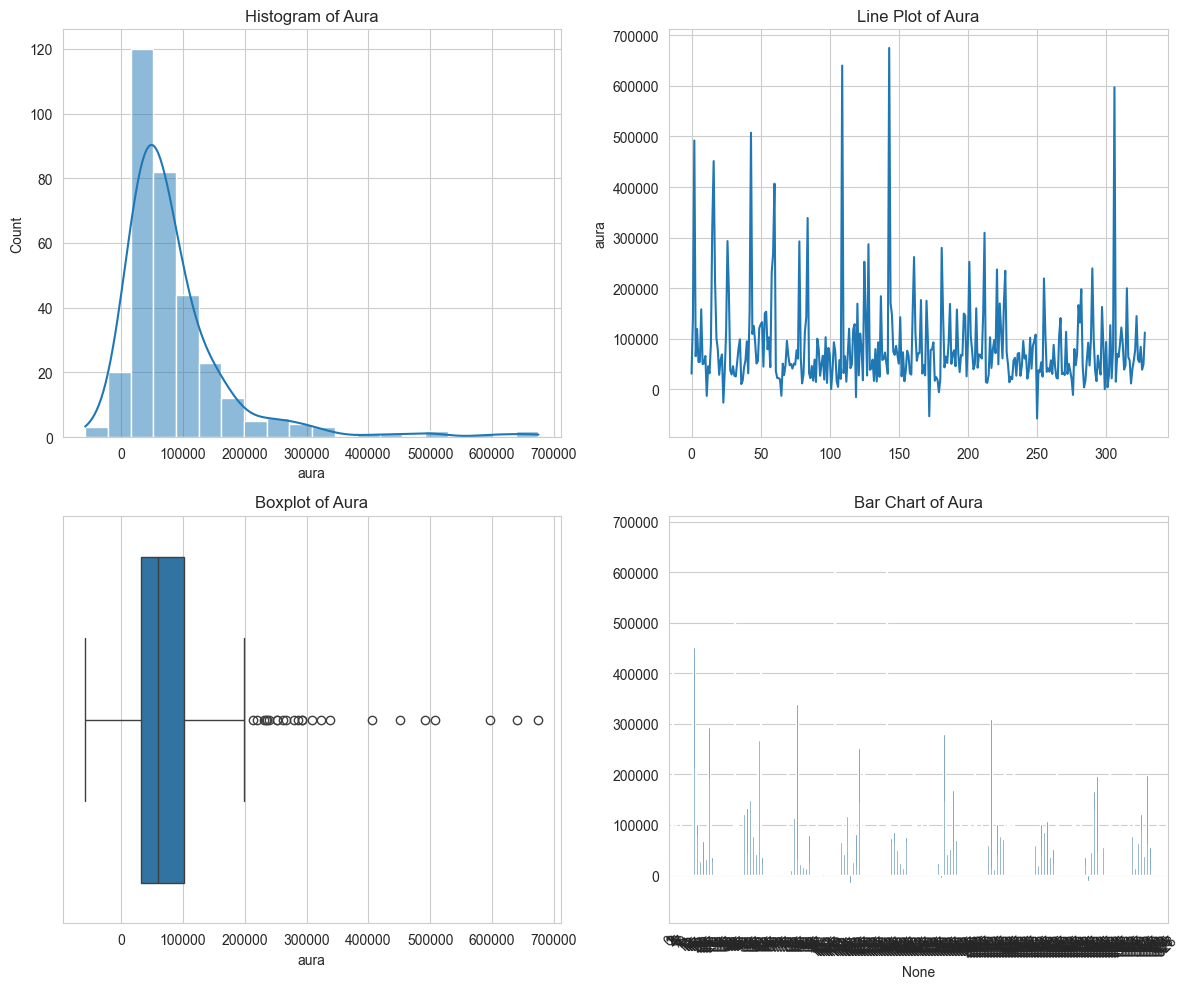

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming user_stats_df['aura'] is already available in the user's environment
aura_data = user_stats_df['aura']

# Set style
sns.set_style("whitegrid")

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Histogram
sns.histplot(aura_data, bins=20, kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Histogram of Aura")

# Line plot
sns.lineplot(data=aura_data, ax=axes[0, 1])
axes[0, 1].set_title("Line Plot of Aura")

# Boxplot
sns.boxplot(x=aura_data, ax=axes[1, 0])
axes[1, 0].set_title("Boxplot of Aura")

# Bar chart (Assuming categorical counts if aura is categorical)
if aura_data.dtype == 'object':
    sns.countplot(y=aura_data, ax=axes[1, 1])
else:
    sns.barplot(x=aura_data.index, y=aura_data.values, ax=axes[1, 1])
axes[1, 1].set_title("Bar Chart of Aura")

# Rotate x-labels for better visibility in bar chart
axes[1, 1].tick_params(axis='x', rotation=45)

# Adjust layout and show
plt.tight_layout()
plt.show()


In [94]:
user_stats_df[['user', 'aura']].sort_values(by='aura').tail(50)

,user,aura
126,Wii_Gii,144554.0
198,fyredoor4,145485.0
145,basbinga,147198.0
211,icep1cke,147793.0
182,emad_c7,147853.0
197,fuzok4,149577.0
53,Hueqi,150210.0
42,Footstep_,152382.0
160,catsspurr,152491.0
54,IRLKingsman,153293.0


In [95]:
user_stats_df[['user', 'spam_count']].sort_values(by='spam_count').head(50)

,user,spam_count
242,neshpinat,0.0
148,bigabugj,0.0
146,beaconstrips420,0.0
141,astrologer_j,0.0
72,Lord_Fy,0.0
243,nevadasieera,0.0
127,Xan_Acnapyx,0.0
253,per8immon,0.0
40,Eyght,0.0
123,VyvrhelII,0.0


In [96]:
print(user_stats_df[['user', 'bit']].sort_values(by='bit').tail(10))

                         user   bit
57            ItzDampSandwich   450
170                   damm1jp   650
297              thebigdogjay   650
281                   shenxir  1275
3                    1SKELTON  1275
16   Aluminiumminimumimmunity  1725
306                uwu_cougar  1950
263                 rebbel576  2325
120                   Vidke04  2375
26                CrazeE420xd  2975


In [97]:
print(user_stats_df[['user', 'longest_streak']].sort_values(by='longest_streak').tail(50))

                         user  longest_streak
120                   Vidke04              29
103                    S_Face              29
128                   Zeololz              30
157              cake_for_me_              30
160                 catsspurr              30
147                  benxbari              30
315                   xan_gny              31
287                smilodon_j              32
182                   emad_c7              32
249                   paaaat_              34
140              astrologer95              35
15                    Aloddin              35
69                   KrieSeaX              35
104                 Sacred1um              37
268             rodrigo_20771              37
280          sercanwinchester              37
282                  shogalul              38
58                IvanOnMyOwn              38
203                  gregg_69              39
290                  stan_iv4              39
197                    fuzok4     

In [98]:
# Assuming user_stats_df is your DataFrame
unique_words = user_stats_df['most_common_word_1'].unique()

# If you want to print them
print(unique_words)

['xqc32' 'the' 'ome44' 'hi' 'you' 'Keepo' 'speed1' 'I' 'FEIN' '1' 'a'
 '!play' 'NOWAYING' 'LOL' 'Joel' '!boost' 'ome99' 'is' 'omE' 'PepeLaugh'
 'English' 'LUL' 'lul' 'druskiDance' 'jah' 'i' 'loeyaKEKW' 'LULW' 'doro'
 'RaveTime' 'ReallyMad' 'Listening' 'WW' 'to' 'Smurfing' 'dome37' 'OOOO'
 'Sadge' 'om' '@dorozea' ':D' '?' 'mhm' 'u' 'Banger' 'PagMan' 'bye'
 'OMEGALUL' 'erbyMariodance' 'TEAM' 'lol' 'ICANT' 'dorozeaHey'
 'BangbooBounce' 'DORO' 'Yay' 'DinoDance' 'dorozeaLOVE'
 'dorozeaTouchingyou' 'WAJAJA' 'YEP' 'Clap' 'STREAMER' 'Headbang'
 'PagChomp' 'xd' 'LETSGO' 'qq' 'mikuPls' 'Pffttt' 'forsenE' '!' 'RAID'
 'dorozeaSlam' 'moustache' 'forsenLaughingAtYou' 'FROM' 'RalpherZ']


In [99]:
# Assuming user_stats_df is your DataFrame
unique_words = user_stats_df['most_common_word_2'].unique()

# If you want to print them
print(unique_words)

['speed1' 'a' 'the' 'i' 'is' 'FEIN' 'Pffttt' 'I' '\U000e0000' 'u'
 'FLASHBANG' 'LOL' 'FEET' 'ome44' 'Tier' 'hi' 'gg' 'dorozeaDance' 'IVANA'
 'qq' 'DORO' 'Joel' 'bye' 'you' 'Only' 'AREYOUAGIRL' 'LUL' 'Smurfing'
 'ffeeveClap' 'OOOO' 'ratomilton' 'ICANT' '?' 'to' 'tuah!' 'DaRRa' '!play'
 'catJAM' 'DoroCheer' 'om' 'OMEYES' 'TITANHOLO' 'WatchingStream' '/' 'hai'
 'omE' 'erbyLuigidance' 'dorozeaSlam' 'GoldPLZ' 'PINK' '@Martin_Gales'
 'yes' 'doro' 'WideRaveTime' 'JinxLUL' 'it' 'TEAM' 'she' 'Kappa'
 'dorozeaTouchingyou' 'lol' '!boos' 'ome96' 'omEE' 'forsenLaughingAtYou'
 'DinoDance' 'EZ' '😂😂😂' 'AlienPls3' 'ome808' 'NO' '!boost' 'ome52'
 'OMEGALUL' 'PepeLaugh' 'Listening' 'mhm' 'paaaat_' 'lul' 'proffko'
 'Jebaited' 'BOOM' 'nt' 'ome32' 'WW' 'dimacut' 'YEIN' 'ome5' 'RUSSIA'
 'MinionHoting' 'Alarm' 'xan_gny' 'CHAT']


In [100]:
# Assuming user_stats_df is your DataFrame
unique_words = user_stats_df['most_common_word_3'].unique()

# If you want to print them
print(unique_words)

['wideSpeedLaugh3' 'you' 'FEIN' 'guys' 'it' 'speed1' 'is' 'EZ' 'jah' 'i'
 'LOL' 'ome32' 'mhm' 'widetime' 'to' 'u' 'the' 'WW' 'GO' 'buh' 'Clap'
 'OOOO' 'ome44' 'LUL' 'BANGER' 'paul' 'ome96' '?' 'CaitThinking'
 '[warning]' 'Cheer1000' 'a' 'xar2EDM' 'arnoldHalt' 'Banger' 'qq' 'TEAM'
 'o7' 'KEKW' '))' 'omE' 'yes' 'PepeLaugh' '\U000e0000' 'hi' 'PAUSENEMOGU'
 'Nebko16' 'Who' 'hello' 'happi' '1' 'bro' 'Joel' 'HUH' 'DORO' 'I' 'gg'
 '@Martin_Gales' 'yyjPopcorn' 'BOOM' 'andrea540Doof' 'dorozeaAlert'
 'SeemsGood' 'cheerleaders' 'aga' 'OMEGALUL' 'muted' 'om'
 'dorozeaDoroMock' 'JARVIS' 'BloodTrail' 'Doro' 'OMEYES' 'INZOIPsyCat'
 'dorozeaWar' 'DinoDance' 'ome5' '@dorozea' '!play' 'yo' 'fein' 'hiii'
 'LULW' 'MEGALUL' 'doro' 'RAID' 'WideHUH' 'FeelsWowMan' 'speed2' 'Tier'
 'NotLikeThis' 'peepoDJ' 'She' 'on' 'IT' 'dorozeaSignOff' 'WITH' 'uuh'
 'NO']


In [101]:
user_stats_df[user_stats_df['user']=='balintboss']

,user,total_messages,total_words,word_per_message,avg_message_per_stream,most_common_word_1,most_common_word_1_count,most_common_word_2,most_common_word_2_count,most_common_word_3,...,last_message_date,last_message_text,cheer,achivments,words_result,spam_count,warn_count,bit,gifts,aura
143,balintboss,35631,140803,3.951699,112.04717,I,2628,the,2546,is,...,2025-05-14 19:24:44+02:00,bye,0,"[1, 1, 1, 1, 1]","[LOL, 1815, dome32, 1132, o7, 857]",1295.0,2,0,0.0,675215.0


In [102]:
user_stats_df[user_stats_df['user']=='Aluminiumminimumimmunity']

,user,total_messages,total_words,word_per_message,avg_message_per_stream,most_common_word_1,most_common_word_1_count,most_common_word_2,most_common_word_2_count,most_common_word_3,...,last_message_date,last_message_text,cheer,achivments,words_result,spam_count,warn_count,bit,gifts,aura
16,Aluminiumminimumimmunity,11025,32730,2.968707,36.266447,FEIN,4647,ome44,3322,widetime,...,2025-05-14 19:24:31+02:00,buhbye bye,20595,"[1, 1, 1, 0, 0]","[ome44, 3322, widetime, 918, bye, 832]",899.0,28,1725,51.0,451302.0


In [103]:
user_stats_df[user_stats_df['user']=='Typhu25']


,user,total_messages,total_words,word_per_message,avg_message_per_stream,most_common_word_1,most_common_word_1_count,most_common_word_2,most_common_word_2_count,most_common_word_3,...,last_message_date,last_message_text,cheer,achivments,words_result,spam_count,warn_count,bit,gifts,aura
119,Typhu25,20127,302178,15.013564,84.567227,FEIN,136876,ome44,50500,speed1,...,2025-05-14 19:23:34+02:00,stay tuned,400,"[1, 1, 1, 1, 0]","[ome44, 50500, speed1, 5703, ome52, 1425]",3972.0,1,0,0.0,-15781.0


In [104]:
user_stats_df.nlargest(10, 'word_per_message')

,user,total_messages,total_words,word_per_message,avg_message_per_stream,most_common_word_1,most_common_word_1_count,most_common_word_2,most_common_word_2_count,most_common_word_3,...,last_message_date,last_message_text,cheer,achivments,words_result,spam_count,warn_count,bit,gifts,aura
119,Typhu25,20127,302178,15.013564,84.567227,FEIN,136876,ome44,50500,speed1,...,2025-05-14 19:23:34+02:00,stay tuned,400,"[1, 1, 1, 1, 0]","[ome44, 50500, speed1, 5703, ome52, 1425]",3972.0,1,0,0.0,-15781.0
109,StreamElements,31096,416921,13.407544,97.786164,the,20305,/,18339,to,...,2025-05-14 19:21:40+02:00,-Twitter: https://twitter.com/dorozeaxd -TikT...,0,"[1, 1, 1, 1, 1]","[WW, 2350, speed1, 1093, CS2, 1084]",579.0,0,0,0.0,640365.0
17,AnAnonymousGifter,1009,10092,10.001982,13.821918,1,1015,Tier,1009,to,...,2025-05-04 15:05:28+02:00,An anonymous user gifted a Tier 1 sub to max17...,0,"[1, 0, 0, 0, 0]",[],789.0,0,0,1364.0,214000.0
43,Fossabot,6420,60502,9.423988,26.311475,English,6100,Only,6100,[warning],...,2025-05-14 17:58:29+02:00,"@AhmadPew, English Only In Chat so mods can mo...",0,"[1, 1, 1, 1, 1]","[mods, 4772, Chatting, 60, Joel, 2]",6.0,0,0,0.0,507472.0
254,peroni_nasturo_azuro,1735,15745,9.074928,25.895522,a,569,you,496,the,...,2024-10-20 19:04:01+02:00,@1206paul_ i refreshed and the code isnt in ch...,0,"[1, 0, 1, 0, 0]","[Pffttt, 31, ok, 19, life, 16]",6.0,0,0,0.0,24829.0
207,hanepirukas1,1216,10661,8.767270,33.777778,YEP,273,is,258,the,...,2024-10-03 17:35:58+02:00,(fart),300,"[1, 0, 0, 0, 0]","[YEP, 273, Hmm, 90, NODDERS, 43]",5.0,0,0,0.0,42410.0
158,captainmark2024,758,6476,8.543536,42.111111,the,168,you,142,is,...,2025-03-15 16:40:06+01:00,trump: Doro must play for 10K in CS or it will...,0,"[0, 0, 0, 0, 0]","[ok, 5, life, 5, hi, 4]",2.0,0,0,0.0,31152.0
95,Randy2D,1702,13685,8.040541,36.212766,LUL,526,I,400,the,...,2025-05-14 19:23:38+02:00,ok bye,0,"[0, 0, 0, 0, 0]","[LOL, 73, bye, 35, ok, 28]",10.0,1,0,0.0,66088.0
83,Nebko16,530,4043,7.628302,35.333333,a,373,to,370,Nebko16,...,2025-05-07 19:14:55+02:00,@JBIN2036 oh nice!,4492,"[0, 0, 0, 0, 0]","[!play, 11, o7, 4, !boost, 1]",309.0,0,425,1168.0,142192.5
190,fcukboii,1777,12903,7.261114,26.522388,DinoDance,1218,Kappa,781,INZOIPsyCat,...,2025-04-24 20:36:53+02:00,Bye byeeeeeeeeeeeee....... We talk tomorrow Di...,0,"[0, 1, 0, 0, 0]","[!play, 13, bye, 5, Paul, 4]",5.0,2,0,0.0,76910.0


In [105]:
user_stats_df.nlargest(10, 'total_streams')

,user,total_messages,total_words,word_per_message,avg_message_per_stream,most_common_word_1,most_common_word_1_count,most_common_word_2,most_common_word_2_count,most_common_word_3,...,last_message_date,last_message_text,cheer,achivments,words_result,spam_count,warn_count,bit,gifts,aura
109,StreamElements,31096,416921,13.407544,97.786164,the,20305,/,18339,to,...,2025-05-14 19:21:40+02:00,-Twitter: https://twitter.com/dorozeaxd -TikT...,0,"[1, 1, 1, 1, 1]","[WW, 2350, speed1, 1093, CS2, 1084]",579.0,0,0,0.0,640365.0
143,balintboss,35631,140803,3.951699,112.047170,I,2628,the,2546,is,...,2025-05-14 19:24:44+02:00,bye,0,"[1, 1, 1, 1, 1]","[LOL, 1815, dome32, 1132, o7, 857]",1295.0,2,0,0.0,675215.0
2,1206paul_,21696,115230,5.311117,71.368421,ome44,3984,the,2742,FEIN,...,2025-05-14 18:58:35+02:00,LOL!,200,"[1, 1, 1, 1, 0]","[ome44, 3984, LETSGO, 996, WW, 697]",1924.0,0,0,1.0,492051.0
16,Aluminiumminimumimmunity,11025,32730,2.968707,36.266447,FEIN,4647,ome44,3322,widetime,...,2025-05-14 19:24:31+02:00,buhbye bye,20595,"[1, 1, 1, 0, 0]","[ome44, 3322, widetime, 918, bye, 832]",899.0,28,1725,51.0,451302.0
144,banties_x,34376,137768,4.007680,117.726027,speed1,8805,FEIN,7147,ome44,...,2025-05-14 18:31:59+02:00,haHAA,10,"[1, 1, 1, 1, 1]","[speed1, 8805, ome44, 6352, widetime, 2881]",4605.0,0,400,7.0,170256.0
15,Aloddin,7121,40560,5.695829,25.432143,I,1151,FEET,1082,mhm,...,2025-05-14 16:04:14+02:00,I'm too exhausted to be angry :(,10,"[1, 1, 0, 1, 1]","[mhm, 998, o7, 279, GIGACHAIR, 234]",154.0,0,0,0.0,323417.0
84,Nightbot,2318,16128,6.957722,8.338129,is,796,tuah!,430,Who,...,2025-05-14 16:53:58+02:00,1920x1080 / 16:9,0,"[1, 1, 0, 1, 0]","[BUSSERS, 5]",11.0,0,0,0.0,338681.0
78,Martin_Gales,42372,250474,5.911309,158.104478,FEIN,17658,ome44,7049,the,...,2025-05-14 16:44:48+02:00,@haHAA_12_btw ahh you only speak freedom o7,526,"[1, 1, 1, 0, 0]","[ome44, 7049, gg, 4538, mhm, 3407]",2140.0,0,0,0.0,292382.0
226,klimzaa,20497,124716,6.084598,78.532567,ome44,12267,ome52,8129,fein,...,2025-05-13 19:06:59+02:00,!play,0,"[1, 1, 1, 1, 0]","[ome44, 12267, ome52, 8129, fein, 7667]",1585.0,0,0,0.0,169646.0
128,Zeololz,4770,21694,4.548008,18.853755,u,529,i,438,the,...,2025-05-14 19:24:25+02:00,what time friday,0,"[1, 1, 1, 1, 0]","[aga, 236, omE, 151, Smile, 142]",5.0,3,0,0.0,286761.0


In [106]:
user_stats_df['total_streams'].describe()

count    329.000000
mean      68.507599
std       61.610060
min        3.000000
25%       26.000000
50%       50.000000
75%       87.000000
max      318.000000
Name: total_streams, dtype: float64

In [107]:
user_stats_df.sort_values(by='last_message_date').head(25)

,user,total_messages,total_words,word_per_message,avg_message_per_stream,most_common_word_1,most_common_word_1_count,most_common_word_2,most_common_word_2_count,most_common_word_3,...,last_message_date,last_message_text,cheer,achivments,words_result,spam_count,warn_count,bit,gifts,aura
243,nevadasieera,519,2234,4.304432,47.181818,the,44,to,42,FeelsWowMan,...,2024-06-11 14:27:10+02:00,i called her friend and now she thinks she's n...,0,"[0, 0, 0, 0, 0]","[FeelsWowMan, 37, FeelsBadMan, 26, BibleThump,...",0.0,0,0,0.0,20819.0
230,lothric_tenz,580,3365,5.801724,82.857143,the,142,you,89,to,...,2024-06-17 19:58:58+02:00,"No worries, you will figure out a strat to bea...",0,"[0, 0, 0, 0, 0]","[LULW, 36, EZ, 26, ok, 15]",9.0,0,0,10.0,13579.0
318,xxxflower1,791,2945,3.723135,79.100000,?,62,the,56,you,...,2024-06-24 14:30:32+02:00,alright,0,"[0, 0, 0, 0, 0]","[OMEGALUL, 47, !play, 24, PepeLaugh, 22]",11.0,0,0,0.0,11186.0
98,RealDrLing,661,2509,3.795764,73.444444,the,81,LUL,64,to,...,2024-06-24 21:14:23+02:00,bye,0,"[0, 0, 0, 0, 0]","[owoCheer, 42, OMEGALUL, 8, !play, 8]",12.0,0,0,10.0,12245.0
157,cake_for_me_,606,784,1.293729,16.833333,lol,52,yes,41,gg,...,2024-07-13 19:08:40+02:00,hi,0,"[0, 0, 0, 0, 0]","[gg, 31, hi, 27, bye, 26]",7.0,0,0,0.0,66523.0
99,Risc__V,2908,10524,3.618982,48.466667,the,228,is,184,you,...,2024-07-24 18:24:00+02:00,CLOWNDETECTED,0,"[0, 0, 0, 0, 0]","[classic, 156, YEP, 132, mhm, 66]",5.0,0,0,0.0,81521.0
108,SercanLeaxl,687,1578,2.296943,68.700000,the,58,WatchingStream,47,LOL,...,2024-08-01 15:48:36+02:00,#ad,0,"[0, 0, 0, 0, 0]","[WatchingStream, 47, LOL, 36, !play, 12]",4.0,1,0,0.0,20275.0
211,icep1cke,1389,2282,1.642909,17.362500,Clap,295,EZ,120,!play,...,2024-08-09 20:48:43+02:00,!play 󠀀,100,"[0, 0, 0, 0, 0]","[Clap, 295, EZ, 120, !play, 102]",10.0,0,0,10.0,147793.0
274,saadr223,678,3342,4.929204,23.379310,you,123,the,109,bro,...,2024-08-22 14:55:02+02:00,bro we use water,0,"[0, 0, 0, 0, 0]","[arthur, 5, life, 3, gg, 2]",3.0,0,0,0.0,36059.0
37,EnthrallPain,589,3359,5.702886,53.545455,PepeLaugh,151,the,105,you,...,2024-09-03 19:59:24+02:00,If you put ice behind your fan it's a mini ac ...,0,"[0, 0, 1, 0, 0]","[PepeLaugh, 151, OMEGALUL, 45, Clueless, 45]",1.0,0,0,0.0,16968.0


In [108]:
user_stats_df['buster_usage'].describe()

count    329.000000
mean       0.419453
std        1.571580
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       15.000000
Name: buster_usage, dtype: float64

In [109]:
user_stats_df[['user', 'cheer']].sort_values(by='cheer').tail(50)

,user,cheer
71,Leftybrasco,10
40,Eyght,10
220,kecso1g,10
282,shogalul,10
32,Dmoz1,10
290,stan_iv4,30
213,ileadarius27,90
267,riesenklotz,100
120,Vidke04,100
184,enseje,100


In [110]:
user_stats_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329 entries, 0 to 328
Data columns (total 40 columns):
 #   Column                    Non-Null Count  Dtype                        
---  ------                    --------------  -----                        
 0   user                      329 non-null    object                       
 1   total_messages            329 non-null    int64                        
 2   total_words               329 non-null    int64                        
 3   word_per_message          329 non-null    float64                      
 4   avg_message_per_stream    329 non-null    float64                      
 5   most_common_word_1        329 non-null    object                       
 6   most_common_word_1_count  329 non-null    int64                        
 7   most_common_word_2        329 non-null    object                       
 8   most_common_word_2_count  329 non-null    int64                        
 9   most_common_word_3        329 non-null    o

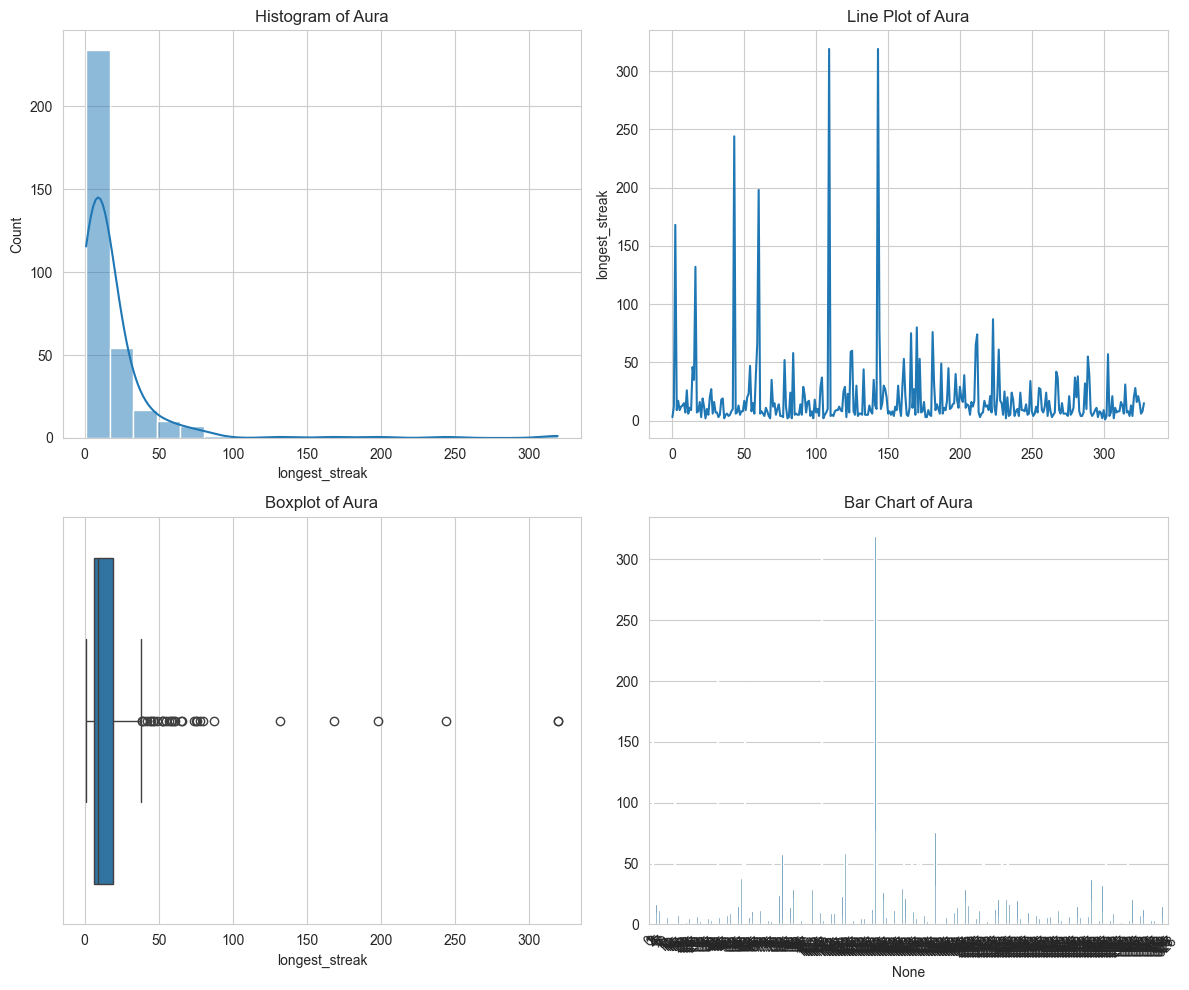

In [111]:

# Assuming user_stats_df['aura'] is already available in the user's environment
longest_streak_data = user_stats_df['longest_streak']

# Set style
sns.set_style("whitegrid")

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Histogram
sns.histplot(longest_streak_data, bins=20, kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Histogram of Aura")

# Line plot
sns.lineplot(data=longest_streak_data, ax=axes[0, 1])
axes[0, 1].set_title("Line Plot of Aura")

# Boxplot
sns.boxplot(x=longest_streak_data, ax=axes[1, 0])
axes[1, 0].set_title("Boxplot of Aura")

# Bar chart (Assuming categorical counts if aura is categorical)
if longest_streak_data.dtype == 'object':
    sns.countplot(y=longest_streak_data, ax=axes[1, 1])
else:
    sns.barplot(x=longest_streak_data.index, y=longest_streak_data.values, ax=axes[1, 1])
axes[1, 1].set_title("Bar Chart of Aura")

# Rotate x-labels for better visibility in bar chart
axes[1, 1].tick_params(axis='x', rotation=45)

# Adjust layout and show
plt.tight_layout()
plt.show()


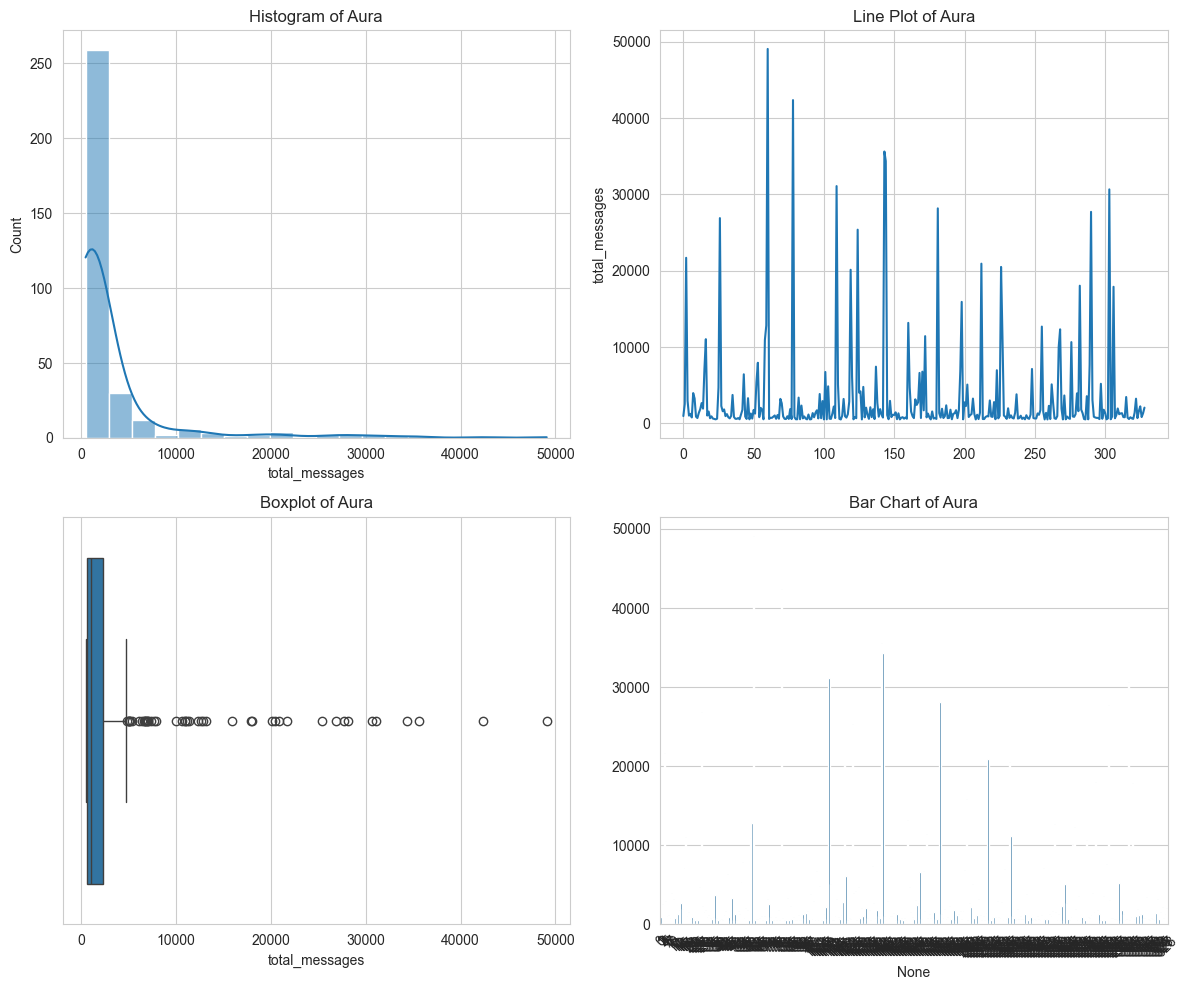

In [112]:

# Assuming user_stats_df['aura'] is already available in the user's environment
total_streams = user_stats_df['total_messages']

# Set style
sns.set_style("whitegrid")

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Histogram
sns.histplot(total_streams, bins=20, kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Histogram of Aura")

# Line plot
sns.lineplot(data=total_streams, ax=axes[0, 1])
axes[0, 1].set_title("Line Plot of Aura")

# Boxplot
sns.boxplot(x=total_streams, ax=axes[1, 0])
axes[1, 0].set_title("Boxplot of Aura")

# Bar chart (Assuming categorical counts if aura is categorical)
if total_streams.dtype == 'object':
    sns.countplot(y=total_streams, ax=axes[1, 1])
else:
    sns.barplot(x=total_streams.index, y=total_streams.values, ax=axes[1, 1])
axes[1, 1].set_title("Bar Chart of Aura")

# Rotate x-labels for better visibility in bar chart
axes[1, 1].tick_params(axis='x', rotation=45)

# Adjust layout and show
plt.tight_layout()
plt.show()


In [113]:
user_stats_df[['user', 'total_messages']].sort_values(by='total_messages').tail(50)

,user,total_messages
125,Wanderer039,4019
126,Wii_Gii,4181
25,Casanovaa,4691
161,chili_con_bacon,4714
128,Zeololz,4770
103,S_Face,4843
202,greekviewer1,5071
110,StunnerGR,5076
262,rautsi__,5102
297,thebigdogjay,5176


In [114]:
user_stats_df['total_messages'].describe()

count      329.000000
mean      3213.240122
std       6423.296775
min        500.000000
25%        660.000000
50%       1021.000000
75%       2318.000000
max      49081.000000
Name: total_messages, dtype: float64

In [115]:
# Assuming user_stats_df is your DataFrame
def extract_unique_words(df, column="words_result"):
    # Extract elements at indices 0, 2, and 4 from each row
    selected_words = df[column].apply(lambda x: [x[0], x[2], x[4]] if len(x) > 4 else [])
    
    # Flatten the list and get unique words
    unique_words = list(set([word for sublist in selected_words for word in sublist]))
    
    return unique_words

# Example usage
unique_result = extract_unique_words(user_stats_df)
print(unique_result)

['FEINFEINFEINFEINFEINFEINFEINFEI', 'gg', 'ReallyMad', '!play', 'monkaW', 'DoroCheer', 'CS2', 'LULW', 'Listening', 'GODDID', 'ome99', 'owoCheer', 'o7', 'YEP', 'ome69', 'BibleThump', 'RIRI', 'ads', 'OMEGALUL', 'ome52', 'Alarm', 'Sadge', 'LETSGO', 'MeWhenIBuyEgyptianProperty', 'forsenPls', 'fein', 'RaveTime', 'Smile', 'FLASHBANG', 'Hmm', 'peepoLove', 'OMEGADANCE', '!unfollow', 'batman', 'bye', 'nt', 'Banties', 'classic', 'qq', 'Sadding', 'wideSpeedLaugh3', 'hiii', 'ADHD', 'hesRight', 'catJAM', '!boost', 'xar2EDM', 'om', 'ayo', 'dash', 'ome32', 'MEGALUL', 'RaveDance', 'ok', 'ratomilton', 'MUGA', 'WIDEALERT', 'mods', 'PAUSENEMOGU', 'buh', 'NODDERS', 'arnoldHalt', 'speed1', 'Xd', 'AINTNOWAY', 'WW', 'hai', 'xqc32', 'LOL', 'PagChomp', 'ahmadmuhsin', 'FeelsWowMan', 'omEE', 'GOONING', 'Stare', 'FeelsBadMan', 'aga', 'GIGACHAIR', 'PepePls', 'ICANT', 'bruv', 'AREYOUAGIRL', 'TITANHOLO', 'arthur', 'NOIDONTTHINKSO', 'dome44', 'AlienPls3', 'plinkVibe', 'JARVIS', 'Pffttt', 'BigD', 'hi', 'speed2', 'uuh'

In [116]:
len(unique_result)

179

In [117]:
# Method 1: Select specific columns by name
selected_columns = ['user','mention_usage','mention_chater','total_messages', 'aura', 'total_words','most_common_word_1','most_common_word_2','most_common_word_3','total_streams','longest_streak','first_message_date','first_message_text','last_message_date','last_message_text','achivments','words_result']
subset_df = user_stats_df[selected_columns]



In [118]:
bots = ['StreamElements', 'Nightbot', 'fuzok4', 'riesenklotz', 'AnAnonymousGifter', 'Fossabot', 'peroni_nasturo_azuro']

subset_df = subset_df[~subset_df['user'].isin(bots)].reset_index(drop=True)

In [119]:
# Export to json
#subset_df.to_json('usersdata.json', index=False)

subset_df.to_json("usersdata.json", orient="records", date_format="iso")

In [120]:
def calculate_user_stats_optimized(df, data, words_list):
    """Calculates various statistics for each user (optimized)."""
    user_stats = []

    for user, user_df in df.groupby("user"):
        messages = user_df["message"].tolist()
        total_messages = len(messages)

        # Efficient total words
        total_words = user_df['message'].str.split().str.len().sum()
        word_per_message = total_words / total_messages if total_messages > 0 else 0

        # Efficient most common words
        all_messages = " ".join(messages)
        most_common_words = Counter(all_messages.split()).most_common(3)
        common_words = [word for word, _ in most_common_words] + [None] * (3 - len(most_common_words))
        common_counts = [count for _, count in most_common_words] + [0] * (3 - len(most_common_words))

        # Efficient keyword usage
        speed1_usage = user_df["message"].str.contains(r"\bspeed1\b", regex=True).sum()
        speed2_usage = user_df["message"].str.contains(r"\bspeed2\b", regex=True).sum()
        ome44_usage = user_df["message"].str.contains(r"\bome44\b", regex=True).sum()
        joel_usage = user_df["message"].str.contains(r"\bJoel\b", regex=True).sum()
        qq_usage = user_df["message"].str.contains(r"\bqq\b", regex=True).sum()
        boost_usage = user_df["message"].str.contains(r"\b!boost\b", regex=True).sum()
        smurf_usage = user_df["message"].str.contains(r"\bSmurfing\b", regex=True).sum()
        bleh_usage = user_df["message"].str.contains(r"\bBleh\b", regex=True).sum()
        play_usage = user_df["message"].str.contains('!play', regex=False).sum()
        buster_usage = user_df["message"].str.lower().str.contains('buster', regex=False).sum()
        peroni_usage = user_df["message"].str.lower().str.contains('peroni', regex=False).sum()
        fien_usage = user_df["message"].str.lower().str.contains('fien', regex=False).sum()
        mention_usage = user_df["message"].str.contains('@', regex=False).sum()
        mention_chater = data["message"].str.contains(user, regex=False).sum() # Careful with 'data' scope

        unique_streams = user_df["stream"].unique().tolist()

        first_message_date = user_df["date"].iloc[0]
        first_message_text = user_df["message"].iloc[0]
        last_message_date = user_df["date"].iloc[-1]
        last_message_text = user_df["message"].iloc[-1]

        # Identify streaks (can potentially be optimized further with vectorized diff)
        count = 1
        last = -1
        longest_streak = 1
        for e in unique_streams:
            if e == (last + 1):
                count += 1
                longest_streak = max(longest_streak, count)
            else:
                count = 1
            last = e

        # Apply the function to create a new column (try to avoid apply if possible)
        user_df["cheer_sum"] = user_df["message"].apply(extract_and_sum)
        cheer = user_df["cheer_sum"].sum()

        # Vectorized achievements
        stream_ids = [112, 184, 102, 177, 258]
        encoded_list = [1 if stream_id in user_df['stream'].values else 0 for stream_id in stream_ids]

        # Efficient filtered word count
        user_messages = user_df["message"].str.split()
        all_user_words = user_messages.explode()
        filtered_user_words = all_user_words[all_user_words.isin(words_list)]
        top_3_filtered = list(filtered_user_words.value_counts().nlargest(3).items())
        words_result = [item for sublist in top_3_filtered for item in sublist] + [None] * (6 - len(top_3_filtered) * 2)

        # Vectorized spam detection
        shifted_df = user_df.shift(1)
        time_diffs = (user_df['date'] - shifted_df['date']).dt.total_seconds()
        similarity = [SequenceMatcher(None, curr, prev).ratio() if pd.notna(prev) else 0
                      for prev, curr in zip(shifted_df['message'], user_df['message'])]
        spam_flag = (time_diffs <= 10) & (pd.Series(similarity) >= 0.6)
        spam_count = spam_flag.sum()

        user_stats.append({
            "user": user,
            "total_messages": total_messages,
            "total_words": total_words,
            "word_per_message": word_per_message,
            "avg_message_per_stream": total_messages / len(unique_streams) if unique_streams else 0,
            "most_common_word_1": common_words[0],
            "most_common_word_1_count": common_counts[0],
            "most_common_word_2": common_words[1],
            "most_common_word_2_count": common_counts[1],
            "most_common_word_3": common_words[2],
            "most_common_word_3_count": common_counts[2],
            "speed1_usage": speed1_usage,
            "speed2_usage": speed2_usage,
            "ome44_usage": ome44_usage,
            "joel_usage": joel_usage,
            "qq_usage": qq_usage,
            "bleh_usage": bleh_usage,
            "boost_usage": boost_usage,
            "buster_usage": buster_usage,
            "peroni_usage": peroni_usage,
            "fien_usage": fien_usage,
            "smurf_usage": smurf_usage,
            "play_usage": play_usage,
            "mention_usage": mention_usage,
            "mention_chater": mention_chater,
            "unique_streams": unique_streams,
            "total_streams": len(unique_streams),
            "longest_streak": longest_streak,
            "first_message_date": first_message_date,
            "first_message_text": first_message_text,
            "last_message_date": last_message_date,
            "last_message_text": last_message_text,
            "cheer": cheer,
            "achivments": encoded_list,
            "words_result": words_result,
            "spam_count": spam_count,
        })

    return pd.DataFrame(user_stats)

# Assuming 'data' and 'words_list' are defined elsewhere
#user_stats_df_optimized = calculate_user_stats_optimized(data_filtered.copy(), data, words_list)

#THIS IS NOT GOOD NOT CALCULATE THE GOOD THING IN IT

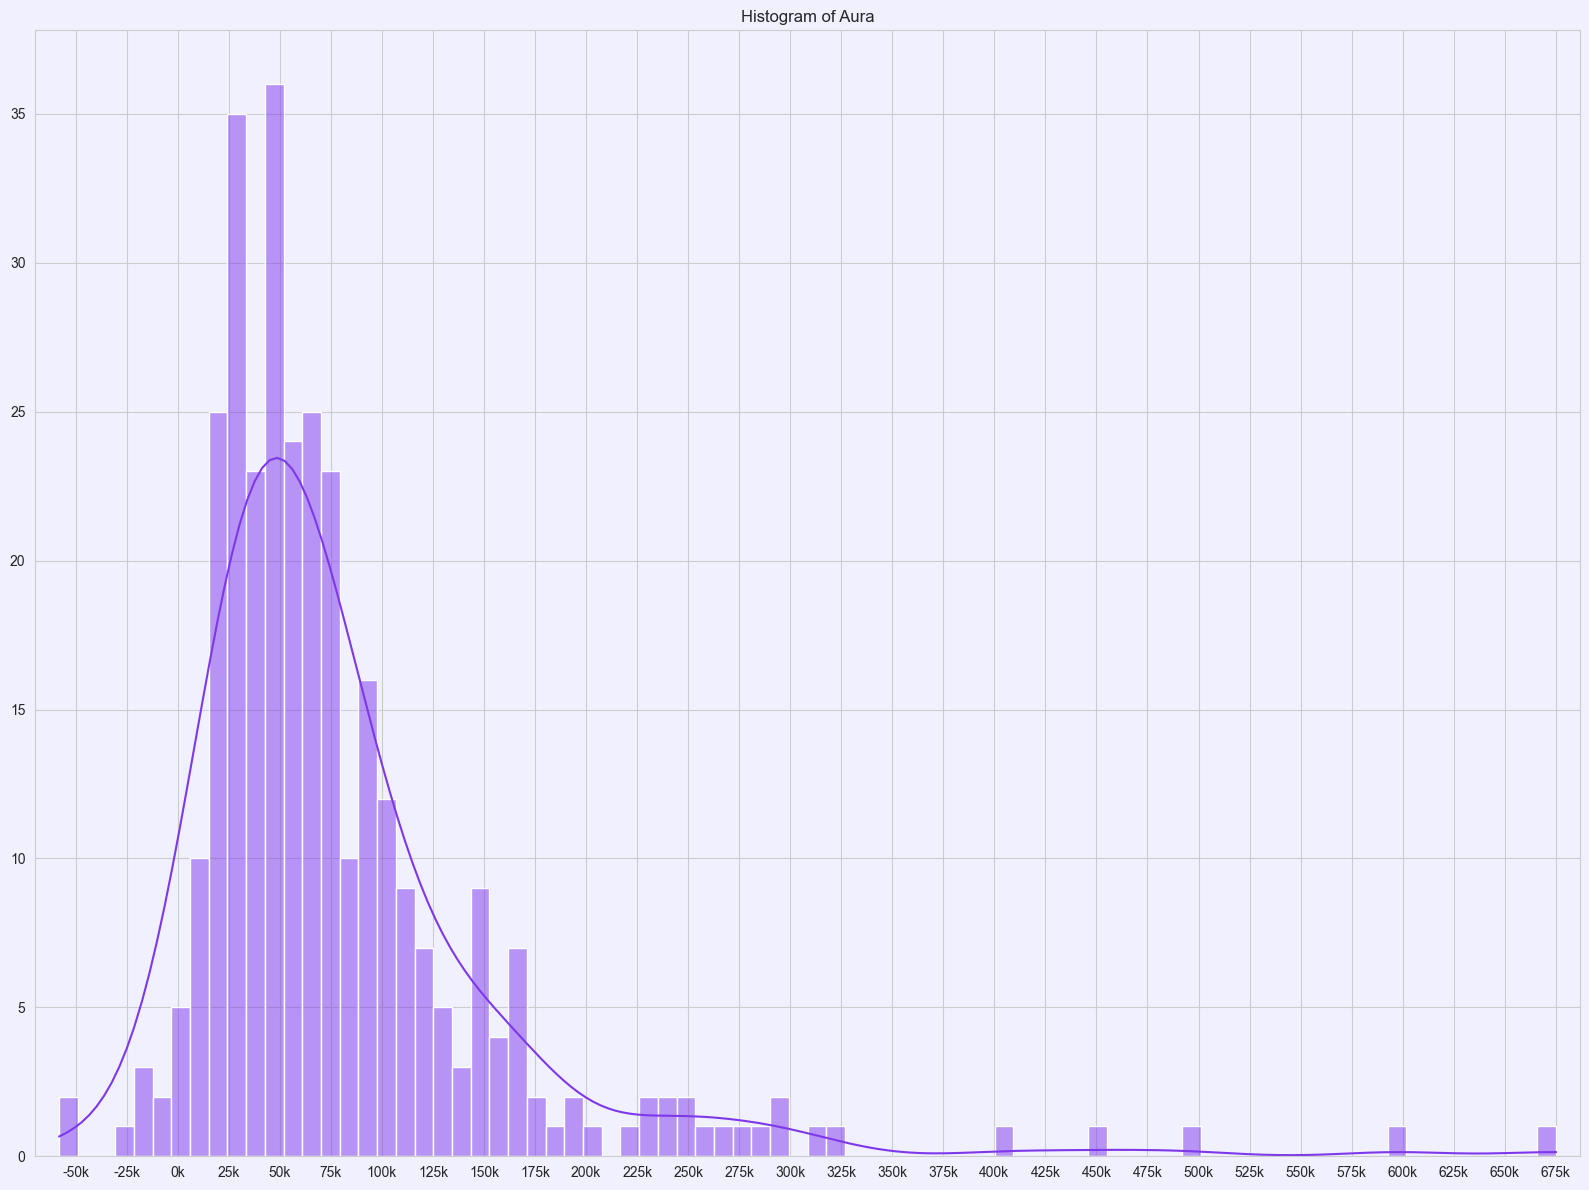

In [121]:
aura_data = subset_df['aura']

# Set style
sns.set_style("whitegrid", {"axes.facecolor": "#F0F0FF", "figure.facecolor": "#F0F0FF"})

# Create a single figure
plt.figure(figsize=(16, 12))

# Histogram with KDE
sns.histplot(   aura_data,
                bins=80, 
                kde=True,
                fill=True,
                color='#7E38EA')
plt.title("Histogram of Aura")

# Format x-axis labels to show "k" notation every 25k
from matplotlib.ticker import FuncFormatter

def thousands_formatter(x, pos):
    return f'{int(x/1000)}k'

plt.gca().xaxis.set_major_formatter(FuncFormatter(thousands_formatter))
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(25000))  # Set ticks every 25,000

# Get current x limits
x_min, x_max = plt.xlim()

# Adjust the limits to remove one tick from start and end
new_x_min = x_min + 25000
new_x_max = x_max - 25000
plt.xlim(new_x_min, new_x_max)

plt.xlabel("")  # Remove x-axis label
plt.ylabel("")  # Remove y-axis label

plt.tight_layout()
plt.show()


In [122]:
aura_data.describe()

count       322.000000
mean      81013.527950
std       83792.989984
min      -58191.000000
25%       32521.500000
50%       59191.000000
75%       98205.000000
max      675215.000000
Name: aura, dtype: float64